# Run to Failure degradation simulation of NASA Turbo Jet Engine Fans

# <a id='index'>Index</a>

+ <a href='#data_analysis'>1. Data Analysis</a>
    + <a href='#info_about_data'>1.1 Info about data:</a>
+ <a href='#noise_removal'>2. Noise removal and Normalization</a>
+ <a href='#training_and_validation'>3. Training and Validation</a>
+ <a href='#testing'>4 Testing</a>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import math
import matplotlib.pyplot as plt
from matplotlib import cm

from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import QuantileTransformer , PowerTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from keras import optimizers
from keras.models import Sequential
from keras.layers import TimeDistributed, Flatten
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from sklearn.metrics import mean_squared_error

import warnings 
warnings.filterwarnings('ignore')

%matplotlib inline
cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.metrics import r2_score

# <a id='data_analysis'>1. Data analysis</a>
<a href='#index'>Go back to Index</a>

In [2]:
train_file = "train_FD001.txt" 
test_file = "test_FD001.txt"
RUL_file = "RUL_FD001.txt"

df = pd.read_csv(train_file,sep=" ",header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [3]:
#columns = ['unit_number','time_in_cycles','setting_1','setting_2','TRA','T2','T24','T30','T50','P2','P15','P30','Nf',
#           'Nc','epr','Ps3 0','phi','NRf','NRc','BPR','farB','htBleed','Nf_dmd','PCNfR_dmd','W31','W32' ]
#delete NaN values
df.drop(columns=[26,27],inplace=True)
columns = ["Section-{}".format(i)  for i in range(26)]
df.columns = columns
df.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


#### Dataset statistics  for each parameter

In [4]:
df.describe()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
count,20631.000000,20631.000000,20631.000000,20631.000000,20631.0,2.063100e+04,20631.000000,20631.000000,20631.000000,2.063100e+04,...,20631.000000,20631.000000,20631.000000,20631.000000,2.063100e+04,20631.000000,20631.0,20631.0,20631.000000,20631.000000
mean,51.506568,108.807862,-0.000009,0.000002,100.0,5.186700e+02,642.680934,1590.523119,1408.933782,1.462000e+01,...,521.413470,2388.096152,8143.752722,8.442146,3.000000e-02,393.210654,2388.0,100.0,38.816271,23.289705
std,29.227633,68.880990,0.002187,0.000293,0.0,6.537152e-11,0.500053,6.131150,9.000605,3.394700e-12,...,0.737553,0.071919,19.076176,0.037505,1.556432e-14,1.548763,0.0,0.0,0.180746,0.108251
min,1.000000,1.000000,-0.008700,-0.000600,100.0,5.186700e+02,641.210000,1571.040000,1382.250000,1.462000e+01,...,518.690000,2387.880000,8099.940000,8.324900,3.000000e-02,388.000000,2388.0,100.0,38.140000,22.894200
25%,26.000000,52.000000,-0.001500,-0.000200,100.0,5.186700e+02,642.325000,1586.260000,1402.360000,1.462000e+01,...,520.960000,2388.040000,8133.245000,8.414900,3.000000e-02,392.000000,2388.0,100.0,38.700000,23.221800
50%,52.000000,104.000000,0.000000,0.000000,100.0,5.186700e+02,642.640000,1590.100000,1408.040000,1.462000e+01,...,521.480000,2388.090000,8140.540000,8.438900,3.000000e-02,393.000000,2388.0,100.0,38.830000,23.297900
75%,77.000000,156.000000,0.001500,0.000300,100.0,5.186700e+02,643.000000,1594.380000,1414.555000,1.462000e+01,...,521.950000,2388.140000,8148.310000,8.465600,3.000000e-02,394.000000,2388.0,100.0,38.950000,23.366800
max,100.000000,362.000000,0.008700,0.000600,100.0,5.186700e+02,644.530000,1616.910000,1441.490000,1.462000e+01,...,523.380000,2388.560000,8293.720000,8.584800,3.000000e-02,400.000000,2388.0,100.0,39.430000,23.618400


## <a id='info_about_data'>1.1 Info about data:</a>
- Section-0 is MachineID
- Section-1 is time in, Cycles
- Section-2...4 is Opertional Settings
- Section-5...25 is sensor's data 


- Data Set: FD001
- Train trjectories: 100
- Test trajectories: 100
- Conditions: ONE (Sea Level)
- Fault Modes: ONE (HPC Degradation)

In [5]:
# Names 
MachineID_name = ["Section-0"]
RUL_name = ["Section-1"]
OS_name = ["Section-{}".format(i) for i in range(2,5)]
Sensor_name = ["Section-{}".format(i) for i in range(5,26)]

# Data in pandas DataFrame
MachineID_data = df[MachineID_name]
RUL_data = df[RUL_name]
OS_data = df[OS_name]
Sensor_data = df[Sensor_name]

# Data in pandas Series
MachineID_series = df["Section-0"]
RUL_series = df["Section-1"]

In [6]:
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
print("Max Life >> ",max(max_cycles))
print("Mean Life >> ",np.mean(max_cycles))
print("Min Life >> ",min(max_cycles))

Max Life >>  362
Mean Life >>  206.31
Min Life >>  128


From the above vizulization its clear that 
- Section-4 (Oprational Setting-3)
- Section-5 (Sensor-1)
- Section-9  (Sensor-5)
- Section-14 (Sensor-10)
- Section-20 (Sensor-16)
- Section-22 (Sensor-18)
- Section-23 (Sensor-19)

Does not play a vital role in variation of data and there std is also almost 0 so, these sensor data is useless for us hence, we can drop this coloumn data

In [7]:
#delete columns with constant values that do not carry information about the state of the unit
#data = pd.concat([RUL_data,OS_data,Sensor_data], axis=1)
df.drop(columns=["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"] , inplace=True)

In [8]:
df.head()

,Section-1,Section-2,Section-3,Section-6,Section-7,Section-8,Section-11,Section-12,Section-13,Section-15,Section-16,Section-17,Section-18,Section-19,Section-21,Section-24,Section-25
0,1,-0.0007,-0.0004,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190
1,2,0.0019,-0.0003,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236
2,3,-0.0043,0.0003,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442
3,4,0.0007,0.0000,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739
4,5,-0.0019,-0.0002,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044


# <a id='noise_removal'>2. Noise removal and Normalization</a>
<a href='#index'>Go back to Index</a>

In [9]:
print(type(df))
gen = MinMaxScaler(feature_range=(0, 1))
df = gen.fit_transform(df)
df = pd.DataFrame(df)
#df = df.rolling(20).mean()
pt = PowerTransformer()
df = pt.fit_transform(df)

<class 'pandas.core.frame.DataFrame'>


In [10]:
df=np.nan_to_num(df)

In [11]:
df

array([[-1.84688137, -0.31975365, -1.3916867 , ..., -0.76399955,
         1.42665355,  1.24248381],
       [-1.82422371,  0.87202066, -1.03174892, ..., -0.76399955,
         1.03734696,  1.29226848],
       [-1.80166973, -1.9503069 ,  1.01385485, ..., -2.35059786,
         0.72414823,  0.465476  ],
       ...,
       [ 1.25582441,  0.18308976,  0.01311911, ...,  2.66650739,
        -1.90974435, -2.75272539],
       [ 1.26682846, -0.50209065,  1.01385485, ...,  1.14636389,
        -2.49938469, -1.91568423],
       [ 1.27779988, -1.45465135, -1.75831429, ...,  1.68933126,
        -2.19492018, -1.99819889]])

In [12]:
# grouping w.r.t MID (Machine ID)
# col_names = df.columns
# def grouping(datafile, mid_series):
#     data = [x for x in datafile.groupby(mid_series)]
#     return data 

# <a id='training_and_validation'>3. Training and Validation using LSTM</a>
<a href='#index'>Go back to Index</a>

In [13]:
def RUL_df():
    rul_lst = [j  for i in MachineID_series.unique() for j in np.array(grp.get_group(i)[::-1]["Section-1"])]
    rul_col = pd.DataFrame({"rul":rul_lst})
    return rul_col

RUL_df().head()

,rul
0,192
1,191
2,190
3,189
4,188


In [14]:
X_train = np.array(df)

y_train = np.array(RUL_df()).reshape(-1,1)

#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20) 


print(X_train.shape,y_train.shape)

(20631, 17) (20631, 1)


In [15]:
X_train_new = []
y_train_new = []
i = 0
count = 0
while i < len(X_train):
    temp_x = []
    temp_y = []
    j = int(max_cycles[count])
    count = count+1
    if j == 0:
        break
    while j!=0:
        temp_x.append(X_train[i])
        temp_y.append(int(y_train[i][0]))
        i=i+1
        j=j-1
    X_train_new.append(temp_x)
    y_train_new.append(temp_y)


In [16]:
print(y_train_new[0])

[192, 191, 190, 189, 188, 187, 186, 185, 184, 183, 182, 181, 180, 179, 178, 177, 176, 175, 174, 173, 172, 171, 170, 169, 168, 167, 166, 165, 164, 163, 162, 161, 160, 159, 158, 157, 156, 155, 154, 153, 152, 151, 150, 149, 148, 147, 146, 145, 144, 143, 142, 141, 140, 139, 138, 137, 136, 135, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122, 121, 120, 119, 118, 117, 116, 115, 114, 113, 112, 111, 110, 109, 108, 107, 106, 105, 104, 103, 102, 101, 100, 99, 98, 97, 96, 95, 94, 93, 92, 91, 90, 89, 88, 87, 86, 85, 84, 83, 82, 81, 80, 79, 78, 77, 76, 75, 74, 73, 72, 71, 70, 69, 68, 67, 66, 65, 64, 63, 62, 61, 60, 59, 58, 57, 56, 55, 54, 53, 52, 51, 50, 49, 48, 47, 46, 45, 44, 43, 42, 41, 40, 39, 38, 37, 36, 35, 34, 33, 32, 31, 30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14, 13, 12, 11, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1]


In [17]:
def create_dataset(X, look_back=5):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)

for i in range(len(X_train_new)):
    X_train_new[i] = create_dataset(X_train_new[i])
    y_train_new[i] = y_train_new[i][6:]
    y_train_new[i] = np.array(y_train_new[i])

In [18]:
def build_model(layers):
        #d = 0.2
        model = Sequential()
        model.add(LSTM(128, input_shape=(layers[1], layers[0]), return_sequences=True))
        #model.add(Dropout(d))
        model.add(LSTM(64, input_shape=(layers[1], layers[0]), return_sequences=False))
        #model.add(Dropout(d))
        model.add(Dense(16,kernel_initializer='uniform',activation='relu'))        
        model.add(Dense(1,kernel_initializer='uniform',activation='relu'))
        model.compile(loss='mean_squared_error',optimizer='adam')
        return model

In [19]:
model = build_model([17,5])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 5, 128)            74752     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 16)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 125,217
Trainable params: 125,217
Non-trainable params: 0
_________________________________________________________________
None


--------------------------------------- Current Engine : 1  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 4s 4s/step - loss: 13636.5000 - val_loss: 275.4937
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 13636.1650 - val_loss: 275.4755
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 13635.7627 - val_loss: 275.4461
Epoch 4/75
1/1 [==============================] - 0s 42ms/step - loss: 13635.3232 - val_loss: 275.4128
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 13634.8105 - val_loss: 275.3793
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 13634.2139 - val_loss: 275.3500
Epoch 7/75
1/1 [==============================] - 0s 54ms/step - loss: 13633.5156 - val_loss: 275.3235
Epoch 8/75
1/1 [==============================] - 0s 29ms/step - loss: 13632.6914 - val_loss: 275.2962
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 13631.7

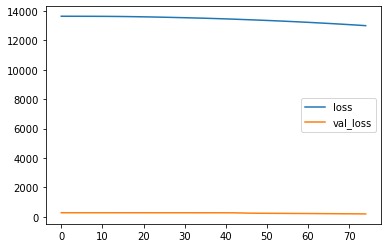

--------------------------------------- Current Engine : 2  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 155ms/step - loss: 30158.5605 - val_loss: 632.3724
Epoch 2/75
1/1 [==============================] - 0s 56ms/step - loss: 30129.3242 - val_loss: 632.2176
Epoch 3/75
1/1 [==============================] - 0s 60ms/step - loss: 30098.8555 - val_loss: 632.0308
Epoch 4/75
1/1 [==============================] - 0s 61ms/step - loss: 30067.6582 - val_loss: 631.8179
Epoch 5/75
1/1 [==============================] - 0s 57ms/step - loss: 30035.7324 - val_loss: 631.5833
Epoch 6/75
1/1 [==============================] - 0s 58ms/step - loss: 30002.7246 - val_loss: 631.3358
Epoch 7/75
1/1 [==============================] - 0s 63ms/step - loss: 29968.0645 - val_loss: 631.0917
Epoch 8/75
1/1 [==============================] - 0s 60ms/step - loss: 29931.4961 - val_loss: 630.9066
Epoch 9/75
1/1 [==============================] - 0s 41ms/step - loss: 2989

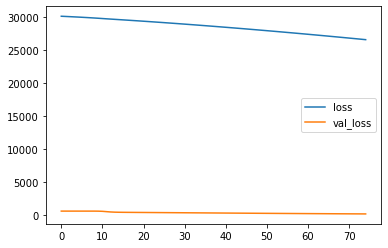

--------------------------------------- Current Engine : 3  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 152ms/step - loss: 9117.0498 - val_loss: 188.2157
Epoch 2/75
1/1 [==============================] - 0s 55ms/step - loss: 9073.5615 - val_loss: 169.2337
Epoch 3/75
1/1 [==============================] - 0s 65ms/step - loss: 9030.2109 - val_loss: 115.0715
Epoch 4/75
1/1 [==============================] - 0s 69ms/step - loss: 8987.1514 - val_loss: 74.1588
Epoch 5/75
1/1 [==============================] - 0s 55ms/step - loss: 8953.2168 - val_loss: 63.9322
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 8913.4668 - val_loss: 62.2564
Epoch 7/75
1/1 [==============================] - 0s 62ms/step - loss: 8881.3984 - val_loss: 62.4713
Epoch 8/75
1/1 [==============================] - 0s 71ms/step - loss: 8852.3301 - val_loss: 63.1615
Epoch 9/75
1/1 [==============================] - 0s 73ms/step - loss: 8824.1094 - val_l

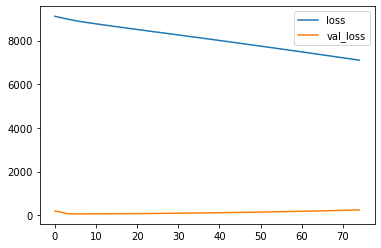

--------------------------------------- Current Engine : 4  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 182ms/step - loss: 8187.3115 - val_loss: 234.5658
Epoch 2/75
1/1 [==============================] - 0s 80ms/step - loss: 8157.3911 - val_loss: 239.6035
Epoch 3/75
1/1 [==============================] - 0s 61ms/step - loss: 8127.2212 - val_loss: 244.7664
Epoch 4/75
1/1 [==============================] - 0s 45ms/step - loss: 8096.8242 - val_loss: 250.0536
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 8066.2192 - val_loss: 255.4642
Epoch 6/75
1/1 [==============================] - 0s 61ms/step - loss: 8035.4258 - val_loss: 260.9977
Epoch 7/75
1/1 [==============================] - 0s 65ms/step - loss: 8004.4604 - val_loss: 266.6534
Epoch 8/75
1/1 [==============================] - 0s 71ms/step - loss: 7973.3394 - val_loss: 272.4309
Epoch 9/75
1/1 [==============================] - 0s 47ms/step - loss: 7942.0776 - 

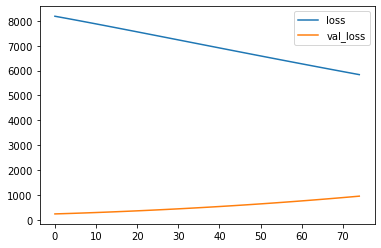

--------------------------------------- Current Engine : 5  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 148ms/step - loss: 15740.6758 - val_loss: 710.4257
Epoch 2/75
1/1 [==============================] - 0s 58ms/step - loss: 15683.9268 - val_loss: 723.8981
Epoch 3/75
1/1 [==============================] - 0s 61ms/step - loss: 15624.0010 - val_loss: 738.2085
Epoch 4/75
1/1 [==============================] - 0s 54ms/step - loss: 15561.2656 - val_loss: 753.3104
Epoch 5/75
1/1 [==============================] - 0s 63ms/step - loss: 15496.0498 - val_loss: 769.1622
Epoch 6/75
1/1 [==============================] - 0s 64ms/step - loss: 15428.6445 - val_loss: 785.7271
Epoch 7/75
1/1 [==============================] - 0s 60ms/step - loss: 15359.3125 - val_loss: 802.9720
Epoch 8/75
1/1 [==============================] - 0s 60ms/step - loss: 15288.2930 - val_loss: 820.8673
Epoch 9/75
1/1 [==============================] - 0s 54ms/step - loss: 1521

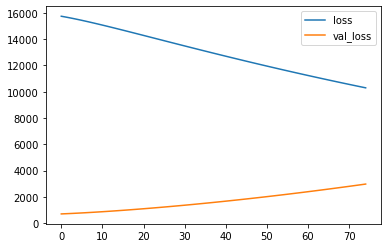

--------------------------------------- Current Engine : 6  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 175ms/step - loss: 3071.3013 - val_loss: 3642.4348
Epoch 2/75
1/1 [==============================] - 0s 62ms/step - loss: 2953.3149 - val_loss: 3686.4961
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 2927.3821 - val_loss: 3728.4202
Epoch 4/75
1/1 [==============================] - 0s 52ms/step - loss: 2905.4983 - val_loss: 3768.3982
Epoch 5/75
1/1 [==============================] - ETA: 0s - loss: 2885.24 - 0s 55ms/step - loss: 2885.2495 - val_loss: 3806.6018
Epoch 6/75
1/1 [==============================] - 0s 48ms/step - loss: 2866.3030 - val_loss: 3843.1863
Epoch 7/75
1/1 [==============================] - 0s 46ms/step - loss: 2848.4839 - val_loss: 3878.2966
Epoch 8/75
1/1 [==============================] - 0s 53ms/step - loss: 2831.6604 - val_loss: 3912.0593
Epoch 9/75
1/1 [==============================] -

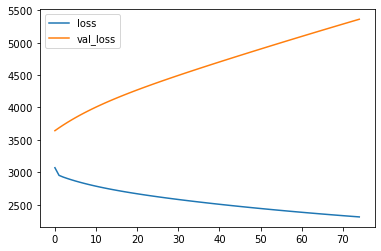

--------------------------------------- Current Engine : 7  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 255ms/step - loss: 7297.5010 - val_loss: 4726.4126
Epoch 2/75
1/1 [==============================] - 0s 132ms/step - loss: 7279.4248 - val_loss: 4750.4438
Epoch 3/75
1/1 [==============================] - 0s 68ms/step - loss: 7258.6738 - val_loss: 4777.3818
Epoch 4/75
1/1 [==============================] - 0s 73ms/step - loss: 7235.5488 - val_loss: 4806.9590
Epoch 5/75
1/1 [==============================] - 0s 82ms/step - loss: 7210.3257 - val_loss: 4838.9360
Epoch 6/75
1/1 [==============================] - 0s 65ms/step - loss: 7183.2480 - val_loss: 4873.0952
Epoch 7/75
1/1 [==============================] - 0s 61ms/step - loss: 7154.5435 - val_loss: 4909.2437
Epoch 8/75
1/1 [==============================] - 0s 62ms/step - loss: 7124.4111 - val_loss: 4947.2046
Epoch 9/75
1/1 [==============================] - 0s 57ms/step - loss: 709

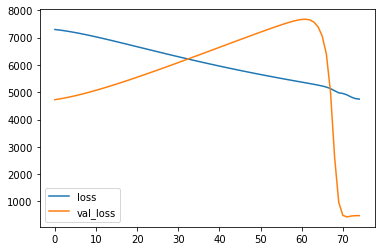

--------------------------------------- Current Engine : 8  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 141ms/step - loss: 822.5478 - val_loss: 126.3169
Epoch 2/75
1/1 [==============================] - 0s 56ms/step - loss: 698.4464 - val_loss: 132.5094
Epoch 3/75
1/1 [==============================] - 0s 66ms/step - loss: 687.5288 - val_loss: 117.0141
Epoch 4/75
1/1 [==============================] - 0s 62ms/step - loss: 628.0917 - val_loss: 88.5338
Epoch 5/75
1/1 [==============================] - 0s 67ms/step - loss: 540.4472 - val_loss: 53.5339
Epoch 6/75
1/1 [==============================] - 0s 57ms/step - loss: 440.7359 - val_loss: 35.9857
Epoch 7/75
1/1 [==============================] - 0s 64ms/step - loss: 343.9484 - val_loss: 84.8722
Epoch 8/75
1/1 [==============================] - 0s 69ms/step - loss: 273.3052 - val_loss: 237.3486
Epoch 9/75
1/1 [==============================] - 0s 65ms/step - loss: 238.6314 - val_loss: 471

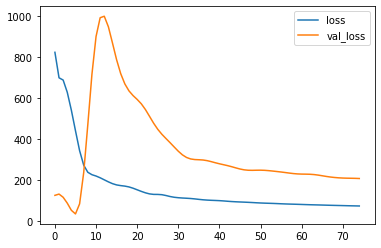

--------------------------------------- Current Engine : 9  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 144ms/step - loss: 2129.2859 - val_loss: 173.0420
Epoch 2/75
1/1 [==============================] - 0s 71ms/step - loss: 2061.0342 - val_loss: 130.2695
Epoch 3/75
1/1 [==============================] - 0s 59ms/step - loss: 1924.7222 - val_loss: 93.2654
Epoch 4/75
1/1 [==============================] - 0s 59ms/step - loss: 1691.1487 - val_loss: 68.8625
Epoch 5/75
1/1 [==============================] - 0s 72ms/step - loss: 1382.2236 - val_loss: 57.2420
Epoch 6/75
1/1 [==============================] - 0s 48ms/step - loss: 1266.0046 - val_loss: 55.0540
Epoch 7/75
1/1 [==============================] - 0s 40ms/step - loss: 1268.2739 - val_loss: 56.7626
Epoch 8/75
1/1 [==============================] - 0s 103ms/step - loss: 1144.0957 - val_loss: 58.3361
Epoch 9/75
1/1 [==============================] - 0s 44ms/step - loss: 1050.3036 - val_l

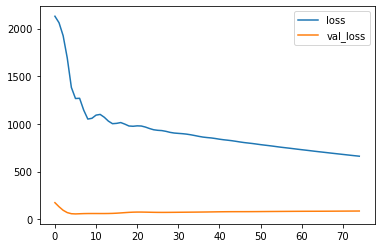

--------------------------------------- Current Engine : 10  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 91ms/step - loss: 1373.7911 - val_loss: 148.6333
Epoch 2/75
1/1 [==============================] - 0s 40ms/step - loss: 1359.7096 - val_loss: 157.0673
Epoch 3/75
1/1 [==============================] - 0s 35ms/step - loss: 1341.9347 - val_loss: 169.8652
Epoch 4/75
1/1 [==============================] - 0s 54ms/step - loss: 1323.0804 - val_loss: 187.7413
Epoch 5/75
1/1 [==============================] - 0s 40ms/step - loss: 1305.1011 - val_loss: 211.4571
Epoch 6/75
1/1 [==============================] - 0s 66ms/step - loss: 1289.1621 - val_loss: 241.5292
Epoch 7/75
1/1 [==============================] - 0s 68ms/step - loss: 1275.6842 - val_loss: 277.8953
Epoch 8/75
1/1 [==============================] - 0s 55ms/step - loss: 1264.5203 - val_loss: 319.6295
Epoch 9/75
1/1 [==============================] - 0s 64ms/step - loss: 1255.1893 - 

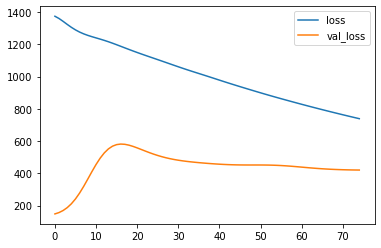

--------------------------------------- Current Engine : 11  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 92ms/step - loss: 1537.3110 - val_loss: 301.9678
Epoch 2/75
1/1 [==============================] - 0s 28ms/step - loss: 1353.0808 - val_loss: 308.6020
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 1309.8243 - val_loss: 316.3844
Epoch 4/75
1/1 [==============================] - 0s 27ms/step - loss: 1330.9988 - val_loss: 324.4745
Epoch 5/75
1/1 [==============================] - 0s 39ms/step - loss: 1363.1139 - val_loss: 332.1877
Epoch 6/75
1/1 [==============================] - 0s 40ms/step - loss: 1377.7084 - val_loss: 339.0677
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 1371.3000 - val_loss: 344.7882
Epoch 8/75
1/1 [==============================] - 0s 31ms/step - loss: 1346.4425 - val_loss: 349.1667
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 1306.6495 - 

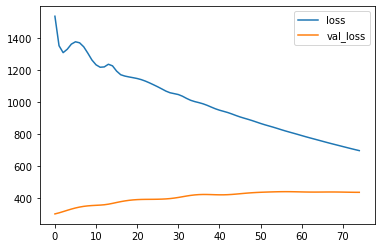

--------------------------------------- Current Engine : 12  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 75ms/step - loss: 1463.1903 - val_loss: 1052.9485
Epoch 2/75
1/1 [==============================] - 0s 40ms/step - loss: 1081.5452 - val_loss: 943.4250
Epoch 3/75
1/1 [==============================] - 0s 25ms/step - loss: 556.0358 - val_loss: 844.9723
Epoch 4/75
1/1 [==============================] - 0s 39ms/step - loss: 199.0972 - val_loss: 768.2727
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 148.1786 - val_loss: 717.4807
Epoch 6/75
1/1 [==============================] - 0s 25ms/step - loss: 355.0605 - val_loss: 692.5344
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 490.5619 - val_loss: 689.1792
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 463.5174 - val_loss: 702.5636
Epoch 9/75
1/1 [==============================] - 0s 80ms/step - loss: 339.4666 - val_lo

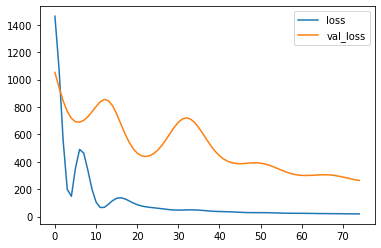

--------------------------------------- Current Engine : 13  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 103ms/step - loss: 202.6963 - val_loss: 226.9250
Epoch 2/75
1/1 [==============================] - 0s 38ms/step - loss: 178.4985 - val_loss: 238.7603
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 140.7541 - val_loss: 257.0367
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 102.7059 - val_loss: 281.5225
Epoch 5/75
1/1 [==============================] - 0s 53ms/step - loss: 74.4559 - val_loss: 311.9828
Epoch 6/75
1/1 [==============================] - 0s 39ms/step - loss: 58.5326 - val_loss: 347.7600
Epoch 7/75
1/1 [==============================] - 0s 40ms/step - loss: 51.8430 - val_loss: 387.5037
Epoch 8/75
1/1 [==============================] - 0s 32ms/step - loss: 51.4148 - val_loss: 429.1274
Epoch 9/75
1/1 [==============================] - 0s 53ms/step - loss: 54.8411 - val_loss: 469

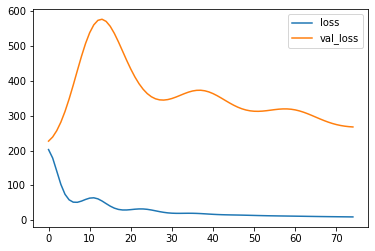

--------------------------------------- Current Engine : 14  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 78ms/step - loss: 405.1955 - val_loss: 249.2149
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 347.2385 - val_loss: 291.5885
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 260.4572 - val_loss: 358.8147
Epoch 4/75
1/1 [==============================] - 0s 39ms/step - loss: 174.6989 - val_loss: 450.7688
Epoch 5/75
1/1 [==============================] - 0s 27ms/step - loss: 112.2986 - val_loss: 558.1721
Epoch 6/75
1/1 [==============================] - 0s 39ms/step - loss: 78.5691 - val_loss: 662.5338
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 69.8637 - val_loss: 742.8954
Epoch 8/75
1/1 [==============================] - 0s 53ms/step - loss: 76.7041 - val_loss: 782.7465
Epoch 9/75
1/1 [==============================] - 0s 25ms/step - loss: 90.9828 - val_loss: 774

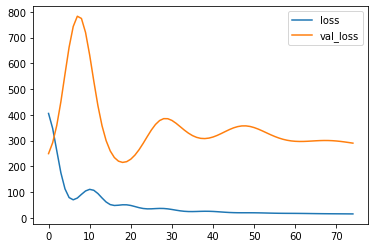

--------------------------------------- Current Engine : 15  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 188ms/step - loss: 786.9806 - val_loss: 752.6007
Epoch 2/75
1/1 [==============================] - 0s 70ms/step - loss: 730.1837 - val_loss: 695.4324
Epoch 3/75
1/1 [==============================] - 0s 48ms/step - loss: 641.6942 - val_loss: 625.9164
Epoch 4/75
1/1 [==============================] - 0s 45ms/step - loss: 547.2514 - val_loss: 551.9476
Epoch 5/75
1/1 [==============================] - 0s 46ms/step - loss: 461.3503 - val_loss: 479.3934
Epoch 6/75
1/1 [==============================] - 0s 70ms/step - loss: 388.9332 - val_loss: 411.9398
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 332.0060 - val_loss: 351.9708
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 287.8482 - val_loss: 300.9863
Epoch 9/75
1/1 [==============================] - 0s 49ms/step - loss: 253.2180 - val_loss

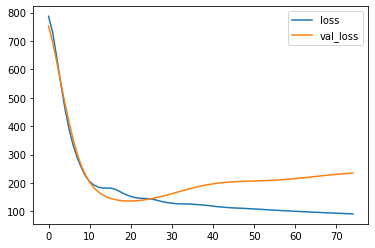

--------------------------------------- Current Engine : 16  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 112ms/step - loss: 3275.6631 - val_loss: 247.2325
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 2901.8213 - val_loss: 306.2862
Epoch 3/75
1/1 [==============================] - 0s 55ms/step - loss: 2366.2727 - val_loss: 414.3586
Epoch 4/75
1/1 [==============================] - 0s 59ms/step - loss: 1784.3888 - val_loss: 602.1640
Epoch 5/75
1/1 [==============================] - 0s 56ms/step - loss: 1225.9305 - val_loss: 896.4440
Epoch 6/75
1/1 [==============================] - 0s 58ms/step - loss: 769.4163 - val_loss: 1298.7942
Epoch 7/75
1/1 [==============================] - 0s 55ms/step - loss: 445.0149 - val_loss: 1793.2142
Epoch 8/75
1/1 [==============================] - 0s 67ms/step - loss: 253.7868 - val_loss: 2388.3982
Epoch 9/75
1/1 [==============================] - 0s 61ms/step - loss: 228.3861 - 

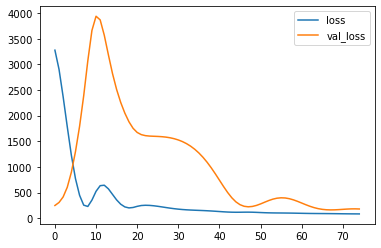

--------------------------------------- Current Engine : 17  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 135ms/step - loss: 4049.5388 - val_loss: 157.8245
Epoch 2/75
1/1 [==============================] - 0s 48ms/step - loss: 3266.0596 - val_loss: 182.9460
Epoch 3/75
1/1 [==============================] - 0s 45ms/step - loss: 2429.0305 - val_loss: 214.4585
Epoch 4/75
1/1 [==============================] - 0s 37ms/step - loss: 1766.1866 - val_loss: 247.5542
Epoch 5/75
1/1 [==============================] - 0s 49ms/step - loss: 1486.4110 - val_loss: 278.2454
Epoch 6/75
1/1 [==============================] - 0s 48ms/step - loss: 1426.7219 - val_loss: 304.2816
Epoch 7/75
1/1 [==============================] - 0s 56ms/step - loss: 1465.9679 - val_loss: 324.4445
Epoch 8/75
1/1 [==============================] - 0s 53ms/step - loss: 1556.8735 - val_loss: 337.9488
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 1653.0653 -

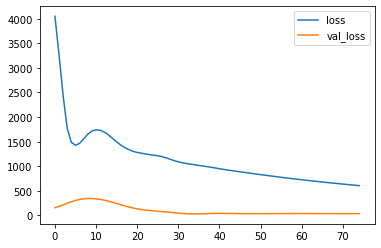

--------------------------------------- Current Engine : 18  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 146ms/step - loss: 3121.0977 - val_loss: 96.6492
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 2740.1602 - val_loss: 74.2267
Epoch 3/75
1/1 [==============================] - 0s 58ms/step - loss: 2052.2485 - val_loss: 51.1700
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 1285.1692 - val_loss: 32.5434
Epoch 5/75
1/1 [==============================] - 0s 56ms/step - loss: 716.6009 - val_loss: 20.9474
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 359.2126 - val_loss: 16.5328
Epoch 7/75
1/1 [==============================] - 0s 46ms/step - loss: 165.2028 - val_loss: 17.9177
Epoch 8/75
1/1 [==============================] - 0s 57ms/step - loss: 253.3043 - val_loss: 22.2463
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 500.1803 - val_loss: 26

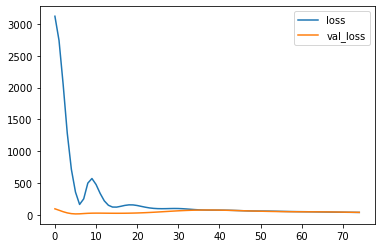

--------------------------------------- Current Engine : 19  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 155ms/step - loss: 5974.1606 - val_loss: 6054.0562
Epoch 2/75
1/1 [==============================] - 0s 55ms/step - loss: 5448.8179 - val_loss: 4573.7280
Epoch 3/75
1/1 [==============================] - 0s 70ms/step - loss: 4733.4058 - val_loss: 3193.8411
Epoch 4/75
1/1 [==============================] - 0s 69ms/step - loss: 4015.6738 - val_loss: 2138.7419
Epoch 5/75
1/1 [==============================] - 0s 72ms/step - loss: 3266.1763 - val_loss: 1428.3699
Epoch 6/75
1/1 [==============================] - 0s 75ms/step - loss: 2538.1543 - val_loss: 975.0640
Epoch 7/75
1/1 [==============================] - 0s 71ms/step - loss: 1892.3203 - val_loss: 683.9540
Epoch 8/75
1/1 [==============================] - 0s 75ms/step - loss: 1343.0873 - val_loss: 495.0250
Epoch 9/75
1/1 [==============================] - 0s 52ms/step - loss: 888.07

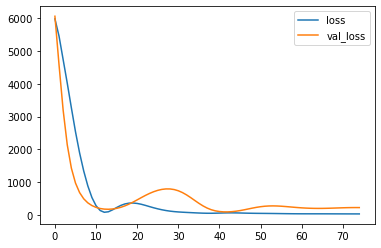

--------------------------------------- Current Engine : 20  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 151ms/step - loss: 2623.1287 - val_loss: 104.6223
Epoch 2/75
1/1 [==============================] - 0s 55ms/step - loss: 2513.6487 - val_loss: 136.0108
Epoch 3/75
1/1 [==============================] - 0s 54ms/step - loss: 2340.3469 - val_loss: 204.0953
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 2143.1521 - val_loss: 324.6333
Epoch 5/75
1/1 [==============================] - 0s 53ms/step - loss: 1953.3761 - val_loss: 507.2719
Epoch 6/75
1/1 [==============================] - 0s 38ms/step - loss: 1788.7426 - val_loss: 749.9205
Epoch 7/75
1/1 [==============================] - 0s 61ms/step - loss: 1654.1718 - val_loss: 1034.0864
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 1544.5695 - val_loss: 1329.4720
Epoch 9/75
1/1 [==============================] - 0s 58ms/step - loss: 1451.3929

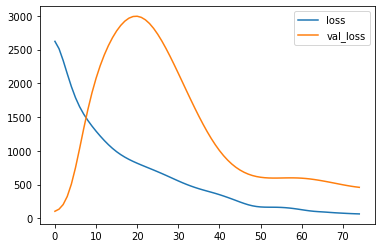

--------------------------------------- Current Engine : 21  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 138ms/step - loss: 2327.6577 - val_loss: 227.1564
Epoch 2/75
1/1 [==============================] - 0s 42ms/step - loss: 2149.5369 - val_loss: 204.7648
Epoch 3/75
1/1 [==============================] - 0s 51ms/step - loss: 1880.2252 - val_loss: 179.1470
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 1607.6045 - val_loss: 153.6914
Epoch 5/75
1/1 [==============================] - 0s 50ms/step - loss: 1393.2262 - val_loss: 130.5489
Epoch 6/75
1/1 [==============================] - 0s 46ms/step - loss: 1209.6732 - val_loss: 110.7569
Epoch 7/75
1/1 [==============================] - 0s 79ms/step - loss: 1033.4866 - val_loss: 94.6998
Epoch 8/75
1/1 [==============================] - 0s 39ms/step - loss: 889.3415 - val_loss: 82.3771
Epoch 9/75
1/1 [==============================] - 0s 66ms/step - loss: 799.5759 - val

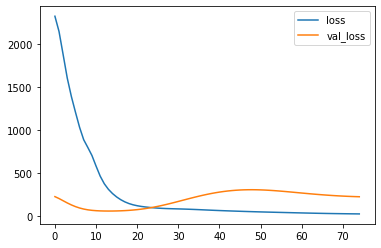

--------------------------------------- Current Engine : 22  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 136ms/step - loss: 717.7287 - val_loss: 505.1781
Epoch 2/75
1/1 [==============================] - 0s 54ms/step - loss: 679.1193 - val_loss: 522.8098
Epoch 3/75
1/1 [==============================] - 0s 60ms/step - loss: 611.9907 - val_loss: 548.8465
Epoch 4/75
1/1 [==============================] - 0s 51ms/step - loss: 528.0214 - val_loss: 582.3153
Epoch 5/75
1/1 [==============================] - 0s 57ms/step - loss: 439.0074 - val_loss: 622.0771
Epoch 6/75
1/1 [==============================] - 0s 56ms/step - loss: 354.6875 - val_loss: 666.6116
Epoch 7/75
1/1 [==============================] - 0s 59ms/step - loss: 280.7321 - val_loss: 713.8271
Epoch 8/75
1/1 [==============================] - 0s 61ms/step - loss: 219.3241 - val_loss: 760.9828
Epoch 9/75
1/1 [==============================] - 0s 52ms/step - loss: 170.5462 - val_loss

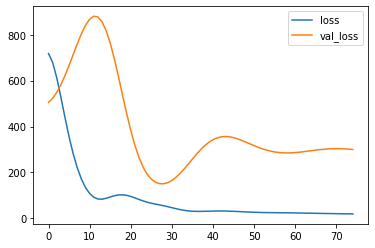

--------------------------------------- Current Engine : 23  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 162ms/step - loss: 1410.6987 - val_loss: 346.7961
Epoch 2/75
1/1 [==============================] - 0s 80ms/step - loss: 1293.8002 - val_loss: 323.3130
Epoch 3/75
1/1 [==============================] - 0s 81ms/step - loss: 1088.4854 - val_loss: 293.7855
Epoch 4/75
1/1 [==============================] - 0s 75ms/step - loss: 819.2827 - val_loss: 261.5497
Epoch 5/75
1/1 [==============================] - 0s 75ms/step - loss: 554.8000 - val_loss: 229.4688
Epoch 6/75
1/1 [==============================] - 0s 78ms/step - loss: 383.2346 - val_loss: 199.6666
Epoch 7/75
1/1 [==============================] - 0s 84ms/step - loss: 334.3735 - val_loss: 173.4792
Epoch 8/75
1/1 [==============================] - 0s 56ms/step - loss: 357.2597 - val_loss: 151.4777
Epoch 9/75
1/1 [==============================] - 0s 65ms/step - loss: 383.6299 - val_l

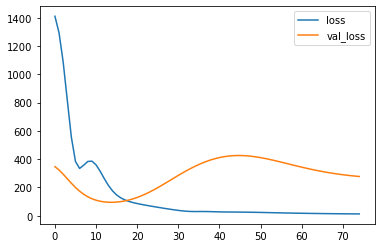

--------------------------------------- Current Engine : 24  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 168ms/step - loss: 1003.8926 - val_loss: 399.8802
Epoch 2/75
1/1 [==============================] - 0s 51ms/step - loss: 837.8152 - val_loss: 385.5666
Epoch 3/75
1/1 [==============================] - 0s 72ms/step - loss: 610.3361 - val_loss: 367.5704
Epoch 4/75
1/1 [==============================] - 0s 51ms/step - loss: 406.7885 - val_loss: 347.2020
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 275.3098 - val_loss: 325.6428
Epoch 6/75
1/1 [==============================] - 0s 40ms/step - loss: 233.6193 - val_loss: 303.9496
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 289.1975 - val_loss: 283.1518
Epoch 8/75
1/1 [==============================] - 0s 70ms/step - loss: 365.9174 - val_loss: 263.9837
Epoch 9/75
1/1 [==============================] - 0s 55ms/step - loss: 334.3232 - val_los

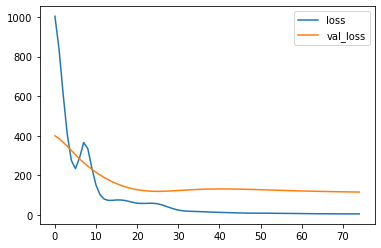

--------------------------------------- Current Engine : 25  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 151ms/step - loss: 4988.2734 - val_loss: 88.3127
Epoch 2/75
1/1 [==============================] - 0s 55ms/step - loss: 4652.6533 - val_loss: 89.7521
Epoch 3/75
1/1 [==============================] - 0s 60ms/step - loss: 4128.5420 - val_loss: 93.5575
Epoch 4/75
1/1 [==============================] - 0s 59ms/step - loss: 3535.5486 - val_loss: 101.0826
Epoch 5/75
1/1 [==============================] - 0s 54ms/step - loss: 2953.3799 - val_loss: 113.6039
Epoch 6/75
1/1 [==============================] - 0s 58ms/step - loss: 2428.2900 - val_loss: 132.2053
Epoch 7/75
1/1 [==============================] - ETA: 0s - loss: 1980.56 - 0s 50ms/step - loss: 1980.5671 - val_loss: 157.7393
Epoch 8/75
1/1 [==============================] - 0s 43ms/step - loss: 1608.2415 - val_loss: 190.8034
Epoch 9/75
1/1 [==============================] - 0s 54ms/s

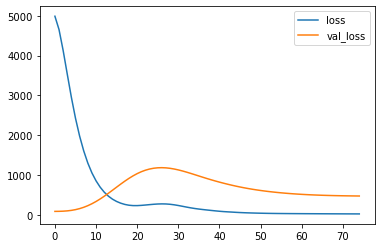

--------------------------------------- Current Engine : 26  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 136ms/step - loss: 199.0000 - val_loss: 535.5087
Epoch 2/75
1/1 [==============================] - 0s 62ms/step - loss: 181.0780 - val_loss: 529.9169
Epoch 3/75
1/1 [==============================] - 0s 66ms/step - loss: 149.7947 - val_loss: 522.8212
Epoch 4/75
1/1 [==============================] - 0s 42ms/step - loss: 114.9140 - val_loss: 514.6982
Epoch 5/75
1/1 [==============================] - 0s 55ms/step - loss: 86.7686 - val_loss: 506.0342
Epoch 6/75
1/1 [==============================] - 0s 58ms/step - loss: 70.2684 - val_loss: 497.2223
Epoch 7/75
1/1 [==============================] - 0s 55ms/step - loss: 63.5368 - val_loss: 488.5219
Epoch 8/75
1/1 [==============================] - 0s 59ms/step - loss: 62.3725 - val_loss: 480.0929
Epoch 9/75
1/1 [==============================] - 0s 58ms/step - loss: 63.5628 - val_loss: 472

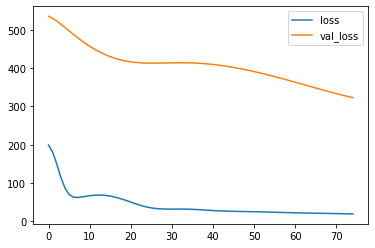

--------------------------------------- Current Engine : 27  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 126ms/step - loss: 1986.7877 - val_loss: 376.6912
Epoch 2/75
1/1 [==============================] - 0s 62ms/step - loss: 1824.9122 - val_loss: 354.8486
Epoch 3/75
1/1 [==============================] - 0s 70ms/step - loss: 1584.8811 - val_loss: 326.3674
Epoch 4/75
1/1 [==============================] - 0s 70ms/step - loss: 1338.7035 - val_loss: 293.0551
Epoch 5/75
1/1 [==============================] - 0s 51ms/step - loss: 1121.6345 - val_loss: 256.4863
Epoch 6/75
1/1 [==============================] - 0s 40ms/step - loss: 935.1124 - val_loss: 218.0637
Epoch 7/75
1/1 [==============================] - 0s 41ms/step - loss: 774.7531 - val_loss: 179.1985
Epoch 8/75
1/1 [==============================] - 0s 61ms/step - loss: 637.2977 - val_loss: 141.4726
Epoch 9/75
1/1 [==============================] - 0s 66ms/step - loss: 518.5254 - val

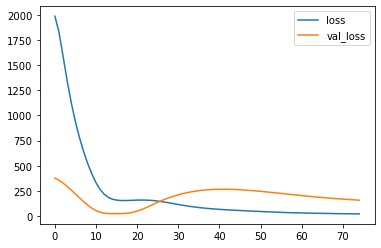

--------------------------------------- Current Engine : 28  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 156ms/step - loss: 272.8188 - val_loss: 225.5210
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 260.4560 - val_loss: 220.7619
Epoch 3/75
1/1 [==============================] - 0s 34ms/step - loss: 243.3712 - val_loss: 215.1910
Epoch 4/75
1/1 [==============================] - 0s 42ms/step - loss: 223.9460 - val_loss: 208.9867
Epoch 5/75
1/1 [==============================] - 0s 58ms/step - loss: 205.0962 - val_loss: 202.3189
Epoch 6/75
1/1 [==============================] - 0s 47ms/step - loss: 189.5049 - val_loss: 195.3401
Epoch 7/75
1/1 [==============================] - 0s 49ms/step - loss: 177.5088 - val_loss: 188.1807
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 167.1775 - val_loss: 180.9447
Epoch 9/75
1/1 [==============================] - 0s 42ms/step - loss: 156.5123 - val_loss

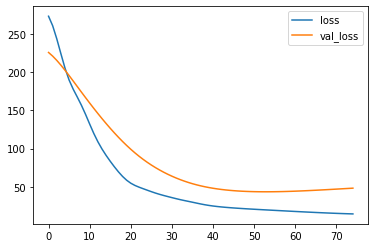

--------------------------------------- Current Engine : 29  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 61ms/step - loss: 50.6438 - val_loss: 59.4161
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 49.3526 - val_loss: 63.9694
Epoch 3/75
1/1 [==============================] - 0s 28ms/step - loss: 47.0655 - val_loss: 70.4659
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 44.1252 - val_loss: 78.7619
Epoch 5/75
1/1 [==============================] - 0s 49ms/step - loss: 40.9420 - val_loss: 88.6492
Epoch 6/75
1/1 [==============================] - 0s 30ms/step - loss: 37.9660 - val_loss: 99.8591
Epoch 7/75
1/1 [==============================] - 0s 40ms/step - loss: 35.5900 - val_loss: 112.0817
Epoch 8/75
1/1 [==============================] - 0s 45ms/step - loss: 33.9223 - val_loss: 124.9934
Epoch 9/75
1/1 [==============================] - 0s 58ms/step - loss: 32.6265 - val_loss: 138.2815
Epoch

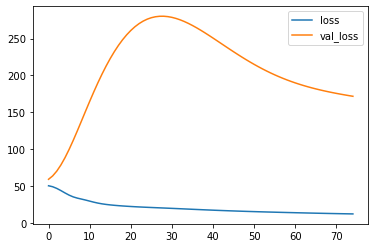

--------------------------------------- Current Engine : 30  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 80ms/step - loss: 489.3727 - val_loss: 257.9423
Epoch 2/75
1/1 [==============================] - 0s 23ms/step - loss: 400.7710 - val_loss: 258.4348
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 286.6009 - val_loss: 259.1822
Epoch 4/75
1/1 [==============================] - 0s 32ms/step - loss: 197.2537 - val_loss: 259.8824
Epoch 5/75
1/1 [==============================] - 0s 30ms/step - loss: 155.1569 - val_loss: 260.2432
Epoch 6/75
1/1 [==============================] - 0s 24ms/step - loss: 154.2889 - val_loss: 260.0361
Epoch 7/75
1/1 [==============================] - 0s 32ms/step - loss: 176.6034 - val_loss: 259.1218
Epoch 8/75
1/1 [==============================] - 0s 46ms/step - loss: 205.2852 - val_loss: 257.4490
Epoch 9/75
1/1 [==============================] - 0s 33ms/step - loss: 228.8257 - val_loss:

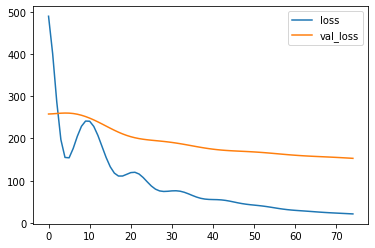

--------------------------------------- Current Engine : 31  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 155ms/step - loss: 1027.9427 - val_loss: 106.4949
Epoch 2/75
1/1 [==============================] - 0s 80ms/step - loss: 925.7219 - val_loss: 109.0714
Epoch 3/75
1/1 [==============================] - 0s 62ms/step - loss: 763.6486 - val_loss: 112.6280
Epoch 4/75
1/1 [==============================] - 0s 46ms/step - loss: 595.0481 - val_loss: 116.8215
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 457.1435 - val_loss: 121.3623
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 363.6033 - val_loss: 125.9943
Epoch 7/75
1/1 [==============================] - 0s 57ms/step - loss: 318.3669 - val_loss: 130.4776
Epoch 8/75
1/1 [==============================] - 0s 40ms/step - loss: 314.3371 - val_loss: 134.6279
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 334.0163 - val_los

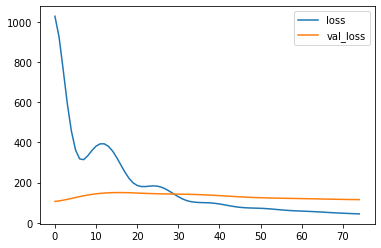

--------------------------------------- Current Engine : 32  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 162ms/step - loss: 464.4523 - val_loss: 82.4059
Epoch 2/75
1/1 [==============================] - 0s 83ms/step - loss: 432.0065 - val_loss: 112.8305
Epoch 3/75
1/1 [==============================] - 0s 66ms/step - loss: 382.7149 - val_loss: 158.1250
Epoch 4/75
1/1 [==============================] - 0s 72ms/step - loss: 328.5756 - val_loss: 212.8732
Epoch 5/75
1/1 [==============================] - 0s 70ms/step - loss: 276.2539 - val_loss: 271.3612
Epoch 6/75
1/1 [==============================] - 0s 57ms/step - loss: 228.2966 - val_loss: 329.9358
Epoch 7/75
1/1 [==============================] - 0s 66ms/step - loss: 185.6887 - val_loss: 387.0967
Epoch 8/75
1/1 [==============================] - 0s 69ms/step - loss: 149.2623 - val_loss: 442.7319
Epoch 9/75
1/1 [==============================] - 0s 54ms/step - loss: 119.4542 - val_loss:

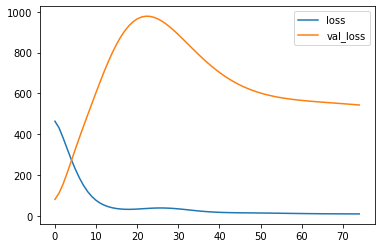

--------------------------------------- Current Engine : 33  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 171ms/step - loss: 532.8165 - val_loss: 899.4661
Epoch 2/75
1/1 [==============================] - 0s 58ms/step - loss: 460.1057 - val_loss: 896.7786
Epoch 3/75
1/1 [==============================] - 0s 73ms/step - loss: 348.5928 - val_loss: 892.6060
Epoch 4/75
1/1 [==============================] - 0s 63ms/step - loss: 241.5334 - val_loss: 886.3781
Epoch 5/75
1/1 [==============================] - 0s 60ms/step - loss: 172.3828 - val_loss: 877.4963
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 149.1875 - val_loss: 865.5638
Epoch 7/75
1/1 [==============================] - 0s 46ms/step - loss: 161.4863 - val_loss: 850.4516
Epoch 8/75
1/1 [==============================] - 0s 46ms/step - loss: 189.0015 - val_loss: 832.3708
Epoch 9/75
1/1 [==============================] - 0s 61ms/step - loss: 210.9225 - val_loss

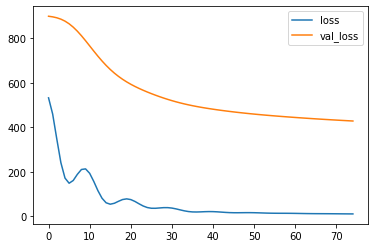

--------------------------------------- Current Engine : 34  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 191ms/step - loss: 384.5924 - val_loss: 374.2577
Epoch 2/75
1/1 [==============================] - 0s 75ms/step - loss: 375.2958 - val_loss: 375.9408
Epoch 3/75
1/1 [==============================] - 0s 69ms/step - loss: 358.4072 - val_loss: 378.4941
Epoch 4/75
1/1 [==============================] - 0s 78ms/step - loss: 335.6344 - val_loss: 381.8403
Epoch 5/75
1/1 [==============================] - 0s 80ms/step - loss: 308.8905 - val_loss: 385.9165
Epoch 6/75
1/1 [==============================] - 0s 96ms/step - loss: 280.1553 - val_loss: 390.6703
Epoch 7/75
1/1 [==============================] - 0s 78ms/step - loss: 251.1050 - val_loss: 396.0600
Epoch 8/75
1/1 [==============================] - 0s 73ms/step - loss: 222.9318 - val_loss: 402.0497
Epoch 9/75
1/1 [==============================] - 0s 68ms/step - loss: 196.4985 - val_loss

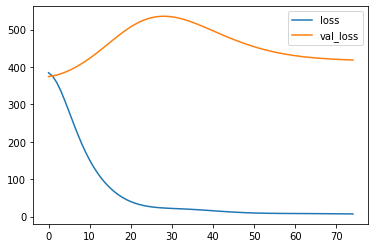

--------------------------------------- Current Engine : 35  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 163ms/step - loss: 290.7649 - val_loss: 498.1888
Epoch 2/75
1/1 [==============================] - 0s 67ms/step - loss: 272.3289 - val_loss: 495.5535
Epoch 3/75
1/1 [==============================] - 0s 72ms/step - loss: 240.2001 - val_loss: 492.0050
Epoch 4/75
1/1 [==============================] - 0s 57ms/step - loss: 201.0020 - val_loss: 487.7242
Epoch 5/75
1/1 [==============================] - 0s 74ms/step - loss: 161.5543 - val_loss: 482.8858
Epoch 6/75
1/1 [==============================] - 0s 74ms/step - loss: 127.3635 - val_loss: 477.6521
Epoch 7/75
1/1 [==============================] - 0s 58ms/step - loss: 101.4929 - val_loss: 472.1693
Epoch 8/75
1/1 [==============================] - 0s 69ms/step - loss: 84.4399 - val_loss: 466.5656
Epoch 9/75
1/1 [==============================] - 0s 65ms/step - loss: 74.8964 - val_loss: 

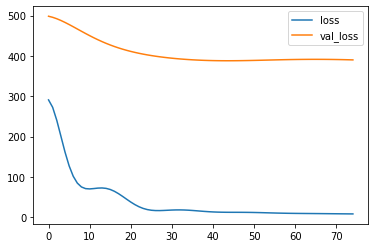

--------------------------------------- Current Engine : 36  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 212ms/step - loss: 213.8574 - val_loss: 540.8336
Epoch 2/75
1/1 [==============================] - 0s 96ms/step - loss: 203.4247 - val_loss: 538.0380
Epoch 3/75
1/1 [==============================] - 0s 88ms/step - loss: 185.4085 - val_loss: 534.1284
Epoch 4/75
1/1 [==============================] - 0s 90ms/step - loss: 162.3091 - val_loss: 529.3441
Epoch 5/75
1/1 [==============================] - 0s 69ms/step - loss: 136.7380 - val_loss: 523.9179
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 111.1353 - val_loss: 518.0645
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 87.5552 - val_loss: 511.9724
Epoch 8/75
1/1 [==============================] - 0s 81ms/step - loss: 67.5257 - val_loss: 505.8015
Epoch 9/75
1/1 [==============================] - 0s 51ms/step - loss: 51.9752 - val_loss: 4

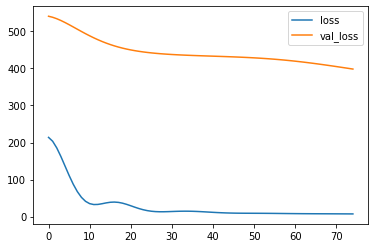

--------------------------------------- Current Engine : 37  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 198ms/step - loss: 91.7095 - val_loss: 473.4969
Epoch 2/75
1/1 [==============================] - 0s 83ms/step - loss: 89.0117 - val_loss: 467.4267
Epoch 3/75
1/1 [==============================] - 0s 95ms/step - loss: 84.2733 - val_loss: 459.7930
Epoch 4/75
1/1 [==============================] - 0s 61ms/step - loss: 77.9787 - val_loss: 451.1091
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 70.6406 - val_loss: 441.8420
Epoch 6/75
1/1 [==============================] - 0s 53ms/step - loss: 62.7667 - val_loss: 432.3813
Epoch 7/75
1/1 [==============================] - 0s 61ms/step - loss: 54.8246 - val_loss: 423.0258
Epoch 8/75
1/1 [==============================] - 0s 86ms/step - loss: 47.2070 - val_loss: 413.9865
Epoch 9/75
1/1 [==============================] - 0s 67ms/step - loss: 40.2039 - val_loss: 405.396

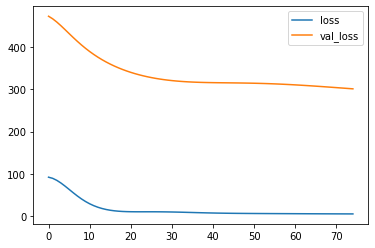

--------------------------------------- Current Engine : 38  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 143ms/step - loss: 707.2621 - val_loss: 180.4733
Epoch 2/75
1/1 [==============================] - 0s 65ms/step - loss: 672.8742 - val_loss: 183.5078
Epoch 3/75
1/1 [==============================] - 0s 73ms/step - loss: 612.7226 - val_loss: 187.9966
Epoch 4/75
1/1 [==============================] - 0s 71ms/step - loss: 536.7680 - val_loss: 193.7982
Epoch 5/75
1/1 [==============================] - 0s 67ms/step - loss: 454.9155 - val_loss: 200.7850
Epoch 6/75
1/1 [==============================] - 0s 81ms/step - loss: 375.8550 - val_loss: 208.8341
Epoch 7/75
1/1 [==============================] - 0s 75ms/step - loss: 306.1184 - val_loss: 217.8229
Epoch 8/75
1/1 [==============================] - 0s 73ms/step - loss: 249.4387 - val_loss: 227.6246
Epoch 9/75
1/1 [==============================] - 0s 47ms/step - loss: 206.7872 - val_loss

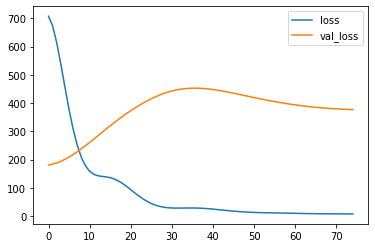

--------------------------------------- Current Engine : 39  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 114ms/step - loss: 3676.3389 - val_loss: 1193.7281
Epoch 2/75
1/1 [==============================] - 0s 48ms/step - loss: 3327.6360 - val_loss: 1119.5430
Epoch 3/75
1/1 [==============================] - 0s 84ms/step - loss: 2798.0811 - val_loss: 1036.7999
Epoch 4/75
1/1 [==============================] - 0s 85ms/step - loss: 2223.5842 - val_loss: 955.0359
Epoch 5/75
1/1 [==============================] - 0s 108ms/step - loss: 1693.4886 - val_loss: 879.0253
Epoch 6/75
1/1 [==============================] - 0s 80ms/step - loss: 1254.0449 - val_loss: 811.0330
Epoch 7/75
1/1 [==============================] - 0s 53ms/step - loss: 911.9122 - val_loss: 751.9279
Epoch 8/75
1/1 [==============================] - 0s 41ms/step - loss: 653.4055 - val_loss: 701.6049
Epoch 9/75
1/1 [==============================] - 0s 78ms/step - loss: 461.8283 

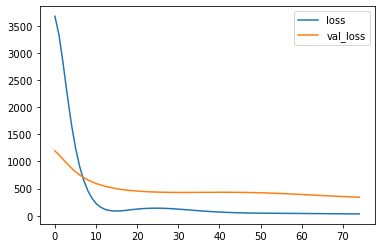

--------------------------------------- Current Engine : 40  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 125ms/step - loss: 2354.6646 - val_loss: 205.7256
Epoch 2/75
1/1 [==============================] - 0s 55ms/step - loss: 2314.1003 - val_loss: 212.6811
Epoch 3/75
1/1 [==============================] - 0s 59ms/step - loss: 2238.8599 - val_loss: 223.1633
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 2137.6079 - val_loss: 236.8678
Epoch 5/75
1/1 [==============================] - 0s 52ms/step - loss: 2018.1842 - val_loss: 253.6511
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 1887.2360 - val_loss: 273.5354
Epoch 7/75
1/1 [==============================] - 0s 54ms/step - loss: 1750.2166 - val_loss: 296.7410
Epoch 8/75
1/1 [==============================] - 0s 51ms/step - loss: 1611.6427 - val_loss: 323.7142
Epoch 9/75
1/1 [==============================] - 0s 48ms/step - loss: 1475.4036 -

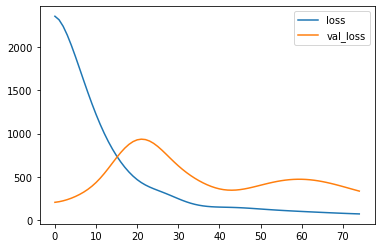

--------------------------------------- Current Engine : 41  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 155ms/step - loss: 446.6897 - val_loss: 351.5471
Epoch 2/75
1/1 [==============================] - 0s 49ms/step - loss: 440.8429 - val_loss: 335.0007
Epoch 3/75
1/1 [==============================] - 0s 54ms/step - loss: 431.8184 - val_loss: 318.1894
Epoch 4/75
1/1 [==============================] - 0s 56ms/step - loss: 420.8693 - val_loss: 301.1927
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 409.1593 - val_loss: 284.0819
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 397.5322 - val_loss: 266.9225
Epoch 7/75
1/1 [==============================] - 0s 46ms/step - loss: 386.4292 - val_loss: 249.7750
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 375.9593 - val_loss: 232.6988
Epoch 9/75
1/1 [==============================] - 0s 45ms/step - loss: 366.0292 - val_loss

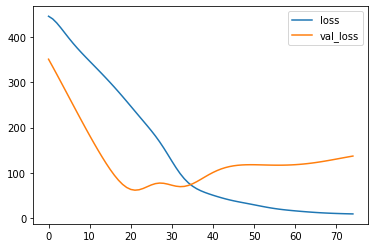

--------------------------------------- Current Engine : 42  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 214ms/step - loss: 275.8514 - val_loss: 463.0763
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 247.0970 - val_loss: 455.7032
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 198.5378 - val_loss: 445.1506
Epoch 4/75
1/1 [==============================] - 0s 54ms/step - loss: 144.5943 - val_loss: 432.2444
Epoch 5/75
1/1 [==============================] - 0s 49ms/step - loss: 99.4667 - val_loss: 417.7752
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 74.0894 - val_loss: 402.4577
Epoch 7/75
1/1 [==============================] - 0s 58ms/step - loss: 69.3729 - val_loss: 386.8572
Epoch 8/75
1/1 [==============================] - 0s 70ms/step - loss: 76.8681 - val_loss: 371.3792
Epoch 9/75
1/1 [==============================] - 0s 60ms/step - loss: 87.5150 - val_loss: 356

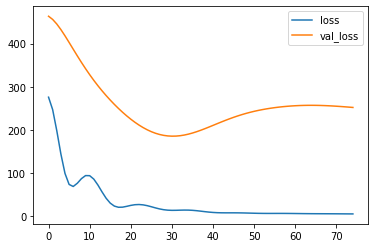

--------------------------------------- Current Engine : 43  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 223ms/step - loss: 98.5664 - val_loss: 413.3547
Epoch 2/75
1/1 [==============================] - 0s 88ms/step - loss: 89.6910 - val_loss: 412.2200
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 75.8782 - val_loss: 410.7927
Epoch 4/75
1/1 [==============================] - 0s 69ms/step - loss: 62.4254 - val_loss: 408.9559
Epoch 5/75
1/1 [==============================] - 0s 83ms/step - loss: 53.2893 - val_loss: 406.6034
Epoch 6/75
1/1 [==============================] - 0s 73ms/step - loss: 49.7032 - val_loss: 403.6624
Epoch 7/75
1/1 [==============================] - 0s 70ms/step - loss: 50.4139 - val_loss: 400.1044
Epoch 8/75
1/1 [==============================] - 0s 94ms/step - loss: 52.8532 - val_loss: 395.9471
Epoch 9/75
1/1 [==============================] - 0s 92ms/step - loss: 54.5218 - val_loss: 391.247

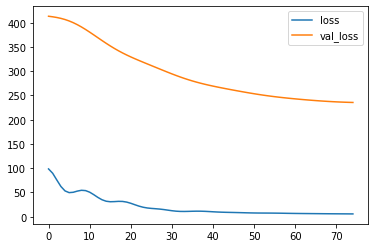

--------------------------------------- Current Engine : 44  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 272ms/step - loss: 102.2078 - val_loss: 103.9661
Epoch 2/75
1/1 [==============================] - 0s 81ms/step - loss: 85.9317 - val_loss: 106.1361
Epoch 3/75
1/1 [==============================] - 0s 140ms/step - loss: 60.7675 - val_loss: 109.3135
Epoch 4/75
1/1 [==============================] - 0s 115ms/step - loss: 36.7204 - val_loss: 113.4896
Epoch 5/75
1/1 [==============================] - 0s 58ms/step - loss: 21.5136 - val_loss: 118.6750
Epoch 6/75
1/1 [==============================] - 0s 67ms/step - loss: 17.4770 - val_loss: 124.8793
Epoch 7/75
1/1 [==============================] - 0s 77ms/step - loss: 21.9414 - val_loss: 132.0885
Epoch 8/75
1/1 [==============================] - 0s 92ms/step - loss: 30.0902 - val_loss: 140.2483
Epoch 9/75
1/1 [==============================] - 0s 71ms/step - loss: 37.2988 - val_loss: 149.

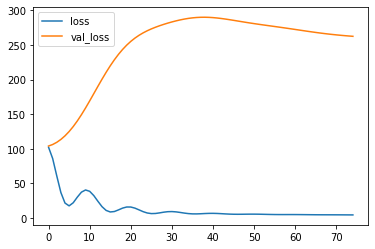

--------------------------------------- Current Engine : 45  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 137ms/step - loss: 922.1008 - val_loss: 251.1935
Epoch 2/75
1/1 [==============================] - 0s 68ms/step - loss: 740.4207 - val_loss: 242.8859
Epoch 3/75
1/1 [==============================] - 0s 41ms/step - loss: 483.5813 - val_loss: 232.3691
Epoch 4/75
1/1 [==============================] - 0s 111ms/step - loss: 262.7555 - val_loss: 220.8146
Epoch 5/75
1/1 [==============================] - 0s 49ms/step - loss: 142.8385 - val_loss: 209.2671
Epoch 6/75
1/1 [==============================] - 0s 103ms/step - loss: 116.2971 - val_loss: 198.3709
Epoch 7/75
1/1 [==============================] - 0s 73ms/step - loss: 140.7280 - val_loss: 188.4527
Epoch 8/75
1/1 [==============================] - 0s 68ms/step - loss: 182.5135 - val_loss: 179.6344
Epoch 9/75
1/1 [==============================] - 0s 61ms/step - loss: 222.9813 - val_lo

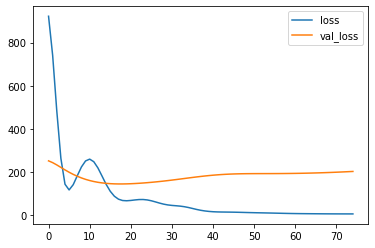

--------------------------------------- Current Engine : 46  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 216ms/step - loss: 5008.5430 - val_loss: 220.0900
Epoch 2/75
1/1 [==============================] - 0s 141ms/step - loss: 4539.8682 - val_loss: 226.0214
Epoch 3/75
1/1 [==============================] - 0s 85ms/step - loss: 3838.2026 - val_loss: 233.9733
Epoch 4/75
1/1 [==============================] - 0s 48ms/step - loss: 3070.2192 - val_loss: 243.5353
Epoch 5/75
1/1 [==============================] - 0s 85ms/step - loss: 2355.2488 - val_loss: 254.3505
Epoch 6/75
1/1 [==============================] - 0s 61ms/step - loss: 1727.1207 - val_loss: 266.0937
Epoch 7/75
1/1 [==============================] - 0s 55ms/step - loss: 1210.1313 - val_loss: 278.4095
Epoch 8/75
1/1 [==============================] - 0s 56ms/step - loss: 834.3657 - val_loss: 291.0033
Epoch 9/75
1/1 [==============================] - 0s 41ms/step - loss: 597.2598 - 

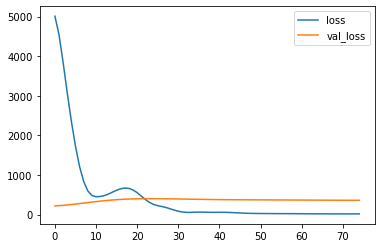

--------------------------------------- Current Engine : 47  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 158ms/step - loss: 966.7572 - val_loss: 297.6512
Epoch 2/75
1/1 [==============================] - 0s 71ms/step - loss: 784.8629 - val_loss: 295.9766
Epoch 3/75
1/1 [==============================] - 0s 80ms/step - loss: 554.3355 - val_loss: 293.8131
Epoch 4/75
1/1 [==============================] - 0s 65ms/step - loss: 383.9229 - val_loss: 291.3920
Epoch 5/75
1/1 [==============================] - 0s 48ms/step - loss: 279.4979 - val_loss: 288.9256
Epoch 6/75
1/1 [==============================] - 0s 58ms/step - loss: 211.0212 - val_loss: 286.5778
Epoch 7/75
1/1 [==============================] - 0s 59ms/step - loss: 167.3714 - val_loss: 284.4864
Epoch 8/75
1/1 [==============================] - 0s 73ms/step - loss: 144.7623 - val_loss: 282.7658
Epoch 9/75
1/1 [==============================] - 0s 85ms/step - loss: 140.3393 - val_loss

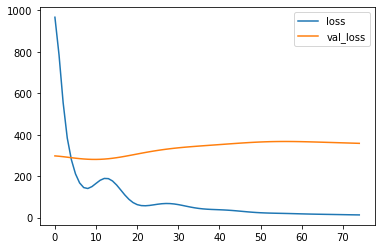

--------------------------------------- Current Engine : 48  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 177ms/step - loss: 239.9636 - val_loss: 333.0714
Epoch 2/75
1/1 [==============================] - 0s 58ms/step - loss: 220.3757 - val_loss: 332.8890
Epoch 3/75
1/1 [==============================] - 0s 54ms/step - loss: 188.8718 - val_loss: 332.7934
Epoch 4/75
1/1 [==============================] - 0s 42ms/step - loss: 152.6497 - val_loss: 332.6839
Epoch 5/75
1/1 [==============================] - 0s 58ms/step - loss: 117.9857 - val_loss: 332.4586
Epoch 6/75
1/1 [==============================] - 0s 58ms/step - loss: 89.4157 - val_loss: 332.0206
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 69.9307 - val_loss: 331.2838
Epoch 8/75
1/1 [==============================] - 0s 41ms/step - loss: 60.2092 - val_loss: 330.1839
Epoch 9/75
1/1 [==============================] - 0s 51ms/step - loss: 58.0731 - val_loss: 32

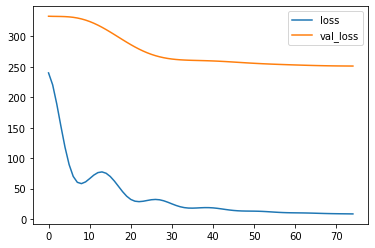

--------------------------------------- Current Engine : 49  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 124ms/step - loss: 53.2256 - val_loss: 409.5323
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 51.6546 - val_loss: 414.7475
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 48.7706 - val_loss: 422.1783
Epoch 4/75
1/1 [==============================] - 0s 32ms/step - loss: 44.9297 - val_loss: 431.5325
Epoch 5/75
1/1 [==============================] - 0s 46ms/step - loss: 40.5126 - val_loss: 442.5271
Epoch 6/75
1/1 [==============================] - 0s 57ms/step - loss: 35.8848 - val_loss: 454.8869
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 31.3648 - val_loss: 468.3452
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 27.2033 - val_loss: 482.6435
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 23.5776 - val_loss: 497.527

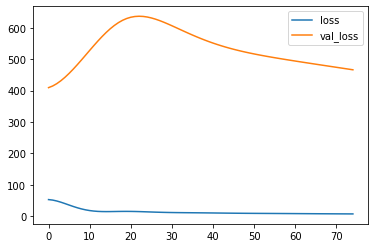

--------------------------------------- Current Engine : 50  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 205ms/step - loss: 271.0444 - val_loss: 286.6622
Epoch 2/75
1/1 [==============================] - 0s 96ms/step - loss: 246.9162 - val_loss: 294.0801
Epoch 3/75
1/1 [==============================] - 0s 81ms/step - loss: 208.0095 - val_loss: 305.0462
Epoch 4/75
1/1 [==============================] - 0s 69ms/step - loss: 164.9644 - val_loss: 318.6930
Epoch 5/75
1/1 [==============================] - 0s 57ms/step - loss: 125.9769 - val_loss: 334.1809
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 95.0883 - val_loss: 350.7384
Epoch 7/75
1/1 [==============================] - 0s 46ms/step - loss: 72.6100 - val_loss: 367.6851
Epoch 8/75
1/1 [==============================] - 0s 72ms/step - loss: 56.8263 - val_loss: 384.4457
Epoch 9/75
1/1 [==============================] - 0s 49ms/step - loss: 45.9949 - val_loss: 40

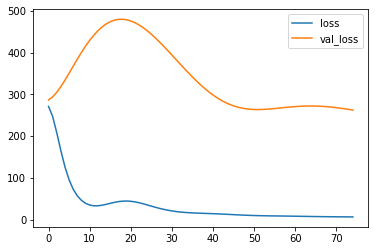

--------------------------------------- Current Engine : 51  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 273ms/step - loss: 128.6329 - val_loss: 305.2736
Epoch 2/75
1/1 [==============================] - 0s 106ms/step - loss: 117.5257 - val_loss: 298.8158
Epoch 3/75
1/1 [==============================] - 0s 136ms/step - loss: 99.6175 - val_loss: 290.6095
Epoch 4/75
1/1 [==============================] - 0s 85ms/step - loss: 79.5759 - val_loss: 281.1283
Epoch 5/75
1/1 [==============================] - 0s 53ms/step - loss: 61.3269 - val_loss: 270.8000
Epoch 6/75
1/1 [==============================] - 0s 86ms/step - loss: 47.4238 - val_loss: 259.9721
Epoch 7/75
1/1 [==============================] - 0s 42ms/step - loss: 38.2316 - val_loss: 248.9065
Epoch 8/75
1/1 [==============================] - 0s 64ms/step - loss: 32.7474 - val_loss: 237.8208
Epoch 9/75
1/1 [==============================] - 0s 51ms/step - loss: 29.7879 - val_loss: 226

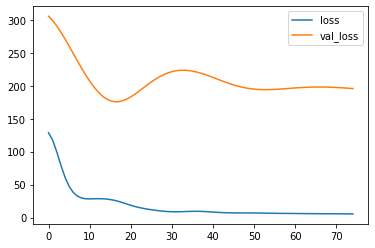

--------------------------------------- Current Engine : 52  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 147ms/step - loss: 35.0860 - val_loss: 244.3521
Epoch 2/75
1/1 [==============================] - 0s 60ms/step - loss: 33.4352 - val_loss: 247.2570
Epoch 3/75
1/1 [==============================] - 0s 68ms/step - loss: 30.5744 - val_loss: 251.4511
Epoch 4/75
1/1 [==============================] - 0s 65ms/step - loss: 26.8996 - val_loss: 256.7243
Epoch 5/75
1/1 [==============================] - 0s 62ms/step - loss: 22.8418 - val_loss: 262.8627
Epoch 6/75
1/1 [==============================] - 0s 78ms/step - loss: 18.8199 - val_loss: 269.6514
Epoch 7/75
1/1 [==============================] - 0s 64ms/step - loss: 15.1974 - val_loss: 276.8779
Epoch 8/75
1/1 [==============================] - 0s 50ms/step - loss: 12.2454 - val_loss: 284.3360
Epoch 9/75
1/1 [==============================] - 0s 44ms/step - loss: 10.1214 - val_loss: 291.829

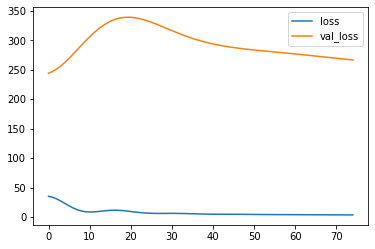

--------------------------------------- Current Engine : 53  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 143ms/step - loss: 184.6809 - val_loss: 215.2349
Epoch 2/75
1/1 [==============================] - 0s 48ms/step - loss: 168.3112 - val_loss: 213.9691
Epoch 3/75
1/1 [==============================] - 0s 62ms/step - loss: 140.9801 - val_loss: 212.4694
Epoch 4/75
1/1 [==============================] - 0s 113ms/step - loss: 109.3451 - val_loss: 210.7909
Epoch 5/75
1/1 [==============================] - 0s 89ms/step - loss: 79.3817 - val_loss: 208.9880
Epoch 6/75
1/1 [==============================] - 0s 60ms/step - loss: 54.8418 - val_loss: 207.1052
Epoch 7/75
1/1 [==============================] - ETA: 0s - loss: 36.70 - 0s 58ms/step - loss: 36.7055 - val_loss: 205.1707
Epoch 8/75
1/1 [==============================] - 0s 65ms/step - loss: 24.3714 - val_loss: 203.1979
Epoch 9/75
1/1 [==============================] - 0s 131ms/step - los

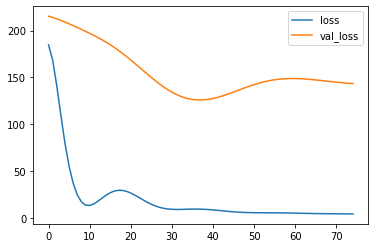

--------------------------------------- Current Engine : 54  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 141ms/step - loss: 1793.1454 - val_loss: 168.9050
Epoch 2/75
1/1 [==============================] - 0s 58ms/step - loss: 1642.5529 - val_loss: 175.1689
Epoch 3/75
1/1 [==============================] - 0s 60ms/step - loss: 1395.8555 - val_loss: 183.9360
Epoch 4/75
1/1 [==============================] - 0s 87ms/step - loss: 1109.4440 - val_loss: 194.6585
Epoch 5/75
1/1 [==============================] - 0s 81ms/step - loss: 827.8883 - val_loss: 206.7354
Epoch 6/75
1/1 [==============================] - 0s 72ms/step - loss: 577.9763 - val_loss: 219.5619
Epoch 7/75
1/1 [==============================] - 0s 47ms/step - loss: 371.8714 - val_loss: 232.5728
Epoch 8/75
1/1 [==============================] - 0s 48ms/step - loss: 217.2035 - val_loss: 245.2361
Epoch 9/75
1/1 [==============================] - 0s 71ms/step - loss: 124.6921 - val_

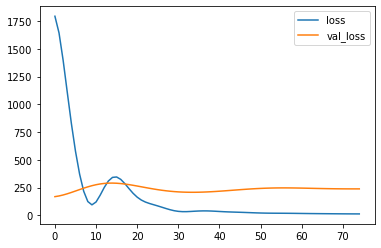

--------------------------------------- Current Engine : 55  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 181ms/step - loss: 1152.8320 - val_loss: 196.3256
Epoch 2/75
1/1 [==============================] - 0s 47ms/step - loss: 1058.0829 - val_loss: 184.9413
Epoch 3/75
1/1 [==============================] - 0s 44ms/step - loss: 909.2695 - val_loss: 169.7841
Epoch 4/75
1/1 [==============================] - 0s 53ms/step - loss: 750.2596 - val_loss: 152.3235
Epoch 5/75
1/1 [==============================] - 0s 71ms/step - loss: 605.9131 - val_loss: 134.0175
Epoch 6/75
1/1 [==============================] - 0s 71ms/step - loss: 479.5038 - val_loss: 116.1777
Epoch 7/75
1/1 [==============================] - 0s 54ms/step - loss: 368.2083 - val_loss: 99.8941
Epoch 8/75
1/1 [==============================] - 0s 52ms/step - loss: 272.0034 - val_loss: 85.9729
Epoch 9/75
1/1 [==============================] - 0s 39ms/step - loss: 193.2634 - val_loss

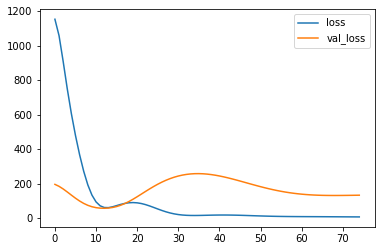

--------------------------------------- Current Engine : 56  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 112ms/step - loss: 4718.3979 - val_loss: 167.0276
Epoch 2/75
1/1 [==============================] - 0s 57ms/step - loss: 4573.4077 - val_loss: 193.4865
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 4323.5273 - val_loss: 233.8442
Epoch 4/75
1/1 [==============================] - 0s 53ms/step - loss: 4000.1165 - val_loss: 289.6979
Epoch 5/75
1/1 [==============================] - 0s 45ms/step - loss: 3629.8748 - val_loss: 364.2890
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 3232.7190 - val_loss: 464.3547
Epoch 7/75
1/1 [==============================] - 0s 34ms/step - loss: 2825.4121 - val_loss: 601.4160
Epoch 8/75
1/1 [==============================] - 0s 61ms/step - loss: 2424.2202 - val_loss: 789.0406
Epoch 9/75
1/1 [==============================] - 0s 64ms/step - loss: 2043.3302 -

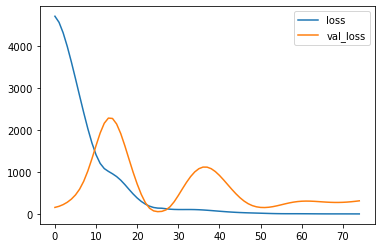

--------------------------------------- Current Engine : 57  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 86ms/step - loss: 17738.4219 - val_loss: 7643.2993
Epoch 2/75
1/1 [==============================] - 0s 55ms/step - loss: 15953.1309 - val_loss: 6857.1172
Epoch 3/75
1/1 [==============================] - 0s 49ms/step - loss: 14394.3750 - val_loss: 6086.3223
Epoch 4/75
1/1 [==============================] - 0s 26ms/step - loss: 13051.6748 - val_loss: 5422.7026
Epoch 5/75
1/1 [==============================] - 0s 46ms/step - loss: 11725.9062 - val_loss: 4861.5557
Epoch 6/75
1/1 [==============================] - 0s 62ms/step - loss: 10422.4189 - val_loss: 4375.0259
Epoch 7/75
1/1 [==============================] - 0s 54ms/step - loss: 9140.3662 - val_loss: 3940.9575
Epoch 8/75
1/1 [==============================] - 0s 49ms/step - loss: 7888.7832 - val_loss: 3549.6882
Epoch 9/75
1/1 [==============================] - 0s 59ms/step - loss

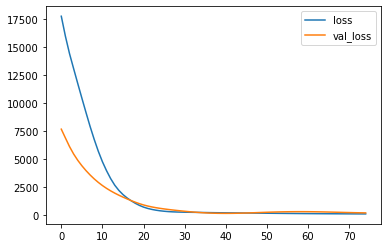

--------------------------------------- Current Engine : 58  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 120ms/step - loss: 158.0592 - val_loss: 47.5969
Epoch 2/75
1/1 [==============================] - 0s 46ms/step - loss: 153.5601 - val_loss: 57.7522
Epoch 3/75
1/1 [==============================] - 0s 61ms/step - loss: 147.0989 - val_loss: 74.1275
Epoch 4/75
1/1 [==============================] - 0s 42ms/step - loss: 139.9982 - val_loss: 96.1704
Epoch 5/75
1/1 [==============================] - 0s 41ms/step - loss: 133.1463 - val_loss: 122.4450
Epoch 6/75
1/1 [==============================] - 0s 87ms/step - loss: 126.9738 - val_loss: 151.0810
Epoch 7/75
1/1 [==============================] - 0s 59ms/step - loss: 121.5899 - val_loss: 180.2027
Epoch 8/75
1/1 [==============================] - 0s 63ms/step - loss: 116.9606 - val_loss: 208.2309
Epoch 9/75
1/1 [==============================] - 0s 49ms/step - loss: 113.0050 - val_loss: 23

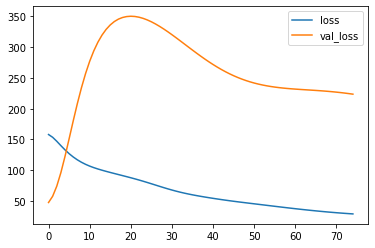

--------------------------------------- Current Engine : 59  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 131ms/step - loss: 2938.3164 - val_loss: 103.3455
Epoch 2/75
1/1 [==============================] - 0s 44ms/step - loss: 2804.9487 - val_loss: 105.8148
Epoch 3/75
1/1 [==============================] - 0s 63ms/step - loss: 2623.4753 - val_loss: 109.5074
Epoch 4/75
1/1 [==============================] - 0s 40ms/step - loss: 2445.5701 - val_loss: 114.2644
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 2282.5637 - val_loss: 119.9602
Epoch 6/75
1/1 [==============================] - ETA: 0s - loss: 2137.10 - 0s 34ms/step - loss: 2137.1030 - val_loss: 126.4632
Epoch 7/75
1/1 [==============================] - 0s 51ms/step - loss: 2014.0660 - val_loss: 133.6286
Epoch 8/75
1/1 [==============================] - 0s 31ms/step - loss: 1909.5986 - val_loss: 141.3204
Epoch 9/75
1/1 [==============================] - 0s 42m

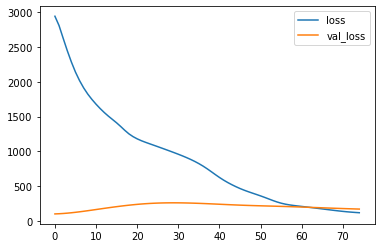

--------------------------------------- Current Engine : 60  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 152ms/step - loss: 154.2783 - val_loss: 21.0201
Epoch 2/75
1/1 [==============================] - 0s 46ms/step - loss: 150.4244 - val_loss: 13.1805
Epoch 3/75
1/1 [==============================] - 0s 54ms/step - loss: 141.9905 - val_loss: 11.3425
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 130.6729 - val_loss: 19.6391
Epoch 5/75
1/1 [==============================] - 0s 95ms/step - loss: 117.8698 - val_loss: 38.4791
Epoch 6/75
1/1 [==============================] - 0s 93ms/step - loss: 104.6470 - val_loss: 65.6293
Epoch 7/75
1/1 [==============================] - 0s 65ms/step - loss: 91.9500 - val_loss: 97.7337
Epoch 8/75
1/1 [==============================] - 0s 60ms/step - loss: 80.7531 - val_loss: 131.4067
Epoch 9/75
1/1 [==============================] - 0s 54ms/step - loss: 71.8322 - val_loss: 163.8322

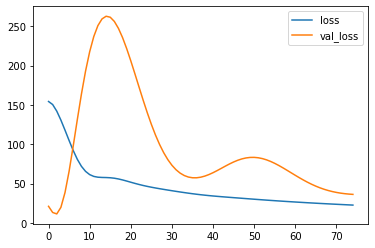

--------------------------------------- Current Engine : 61  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 113ms/step - loss: 758.2224 - val_loss: 556.0130
Epoch 2/75
1/1 [==============================] - 0s 72ms/step - loss: 671.3270 - val_loss: 551.8287
Epoch 3/75
1/1 [==============================] - 0s 45ms/step - loss: 533.8265 - val_loss: 545.6029
Epoch 4/75
1/1 [==============================] - 0s 47ms/step - loss: 378.0232 - val_loss: 537.7883
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 243.3506 - val_loss: 528.8138
Epoch 6/75
1/1 [==============================] - 0s 43ms/step - loss: 154.4150 - val_loss: 519.0532
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 111.4353 - val_loss: 508.8115
Epoch 8/75
1/1 [==============================] - 0s 53ms/step - loss: 108.7460 - val_loss: 498.3246
Epoch 9/75
1/1 [==============================] - 0s 60ms/step - loss: 134.5925 - val_loss

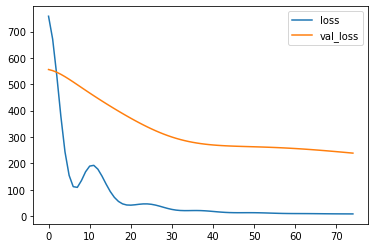

--------------------------------------- Current Engine : 62  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 226ms/step - loss: 1833.4460 - val_loss: 227.3872
Epoch 2/75
1/1 [==============================] - 0s 65ms/step - loss: 1744.1206 - val_loss: 269.7618
Epoch 3/75
1/1 [==============================] - 0s 63ms/step - loss: 1613.6333 - val_loss: 330.6162
Epoch 4/75
1/1 [==============================] - 0s 50ms/step - loss: 1467.0793 - val_loss: 407.5113
Epoch 5/75
1/1 [==============================] - 0s 46ms/step - loss: 1317.1096 - val_loss: 492.6586
Epoch 6/75
1/1 [==============================] - 0s 46ms/step - loss: 1167.0048 - val_loss: 575.5511
Epoch 7/75
1/1 [==============================] - 0s 42ms/step - loss: 1017.4001 - val_loss: 649.8719
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 869.6810 - val_loss: 716.4755
Epoch 9/75
1/1 [==============================] - 0s 41ms/step - loss: 727.2388 - v

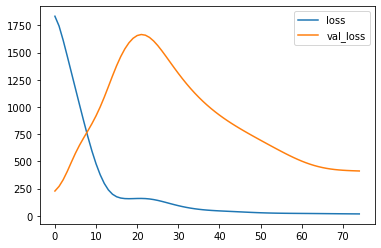

--------------------------------------- Current Engine : 63  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 102ms/step - loss: 357.8118 - val_loss: 11.6932
Epoch 2/75
1/1 [==============================] - 0s 26ms/step - loss: 340.7513 - val_loss: 11.9240
Epoch 3/75
1/1 [==============================] - 0s 45ms/step - loss: 311.8680 - val_loss: 12.6075
Epoch 4/75
1/1 [==============================] - 0s 41ms/step - loss: 275.7124 - val_loss: 13.3763
Epoch 5/75
1/1 [==============================] - 0s 38ms/step - loss: 236.7573 - val_loss: 13.6566
Epoch 6/75
1/1 [==============================] - 0s 41ms/step - loss: 198.6893 - val_loss: 13.1009
Epoch 7/75
1/1 [==============================] - 0s 41ms/step - loss: 163.9861 - val_loss: 11.7489
Epoch 8/75
1/1 [==============================] - 0s 25ms/step - loss: 133.9694 - val_loss: 9.9139
Epoch 9/75
1/1 [==============================] - 0s 55ms/step - loss: 109.0695 - val_loss: 7.9854


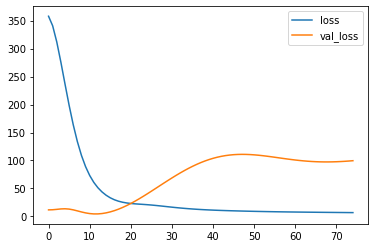

--------------------------------------- Current Engine : 64  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 55ms/step - loss: 7175.2393 - val_loss: 116.1820
Epoch 2/75
1/1 [==============================] - 0s 31ms/step - loss: 6978.8657 - val_loss: 124.8970
Epoch 3/75
1/1 [==============================] - 0s 33ms/step - loss: 6647.6494 - val_loss: 137.5525
Epoch 4/75
1/1 [==============================] - 0s 34ms/step - loss: 6231.0815 - val_loss: 154.0606
Epoch 5/75
1/1 [==============================] - 0s 32ms/step - loss: 5771.3193 - val_loss: 174.3434
Epoch 6/75
1/1 [==============================] - 0s 33ms/step - loss: 5299.7793 - val_loss: 198.3421
Epoch 7/75
1/1 [==============================] - 0s 31ms/step - loss: 4835.9282 - val_loss: 226.0437
Epoch 8/75
1/1 [==============================] - 0s 42ms/step - loss: 4385.6724 - val_loss: 257.5202
Epoch 9/75
1/1 [==============================] - 0s 26ms/step - loss: 3955.1841 - 

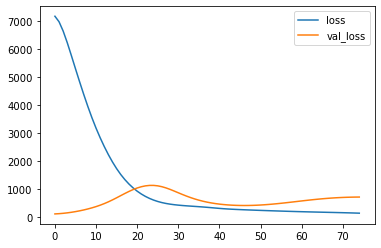

--------------------------------------- Current Engine : 65  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 71ms/step - loss: 17361.2285 - val_loss: 2627.5723
Epoch 2/75
1/1 [==============================] - 0s 39ms/step - loss: 16782.5391 - val_loss: 2583.4634
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 15845.5430 - val_loss: 2522.5381
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 14654.5391 - val_loss: 2448.7048
Epoch 5/75
1/1 [==============================] - 0s 37ms/step - loss: 13201.7559 - val_loss: 2364.6221
Epoch 6/75
1/1 [==============================] - 0s 27ms/step - loss: 11493.7012 - val_loss: 2272.6487
Epoch 7/75
1/1 [==============================] - 0s 37ms/step - loss: 9651.8994 - val_loss: 2174.7190
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 7776.3330 - val_loss: 2072.3738
Epoch 9/75
1/1 [==============================] - 0s 38ms/step - loss

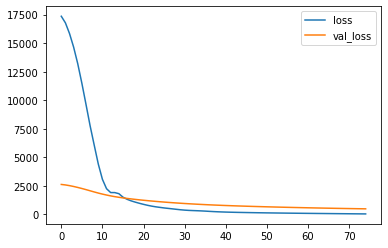

--------------------------------------- Current Engine : 66  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 63ms/step - loss: 2571.1711 - val_loss: 309.1524
Epoch 2/75
1/1 [==============================] - 0s 25ms/step - loss: 2519.0488 - val_loss: 330.1414
Epoch 3/75
1/1 [==============================] - 0s 26ms/step - loss: 2419.0503 - val_loss: 357.8041
Epoch 4/75
1/1 [==============================] - 0s 23ms/step - loss: 2278.3162 - val_loss: 389.8582
Epoch 5/75
1/1 [==============================] - 0s 23ms/step - loss: 2091.7344 - val_loss: 424.5901
Epoch 6/75
1/1 [==============================] - 0s 24ms/step - loss: 1870.0853 - val_loss: 460.9457
Epoch 7/75
1/1 [==============================] - 0s 24ms/step - loss: 1663.9237 - val_loss: 498.4577
Epoch 8/75
1/1 [==============================] - 0s 27ms/step - loss: 1470.7086 - val_loss: 536.9362
Epoch 9/75
1/1 [==============================] - 0s 32ms/step - loss: 1286.2202 - 

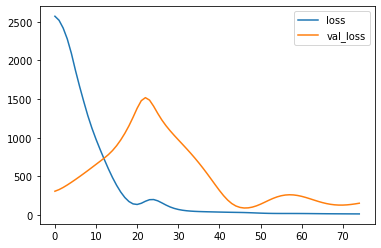

--------------------------------------- Current Engine : 67  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 61ms/step - loss: 15350.2393 - val_loss: 140.2622
Epoch 2/75
1/1 [==============================] - 0s 32ms/step - loss: 13557.0049 - val_loss: 149.9284
Epoch 3/75
1/1 [==============================] - 0s 38ms/step - loss: 11782.7852 - val_loss: 160.7923
Epoch 4/75
1/1 [==============================] - 0s 32ms/step - loss: 10531.1055 - val_loss: 173.6234
Epoch 5/75
1/1 [==============================] - 0s 27ms/step - loss: 9602.2295 - val_loss: 188.5529
Epoch 6/75
1/1 [==============================] - 0s 38ms/step - loss: 8824.3760 - val_loss: 205.5320
Epoch 7/75
1/1 [==============================] - 0s 32ms/step - loss: 8123.3989 - val_loss: 224.5533
Epoch 8/75
1/1 [==============================] - 0s 30ms/step - loss: 7476.7056 - val_loss: 245.4780
Epoch 9/75
1/1 [==============================] - 0s 32ms/step - loss: 6874.057

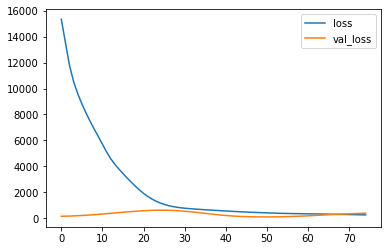

--------------------------------------- Current Engine : 68  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 63ms/step - loss: 5955.5684 - val_loss: 625.3730
Epoch 2/75
1/1 [==============================] - 0s 28ms/step - loss: 5772.4209 - val_loss: 542.8718
Epoch 3/75
1/1 [==============================] - 0s 28ms/step - loss: 5437.7651 - val_loss: 435.3032
Epoch 4/75
1/1 [==============================] - 0s 26ms/step - loss: 4969.8057 - val_loss: 315.7442
Epoch 5/75
1/1 [==============================] - 0s 34ms/step - loss: 4394.9976 - val_loss: 198.5266
Epoch 6/75
1/1 [==============================] - 0s 26ms/step - loss: 3761.2732 - val_loss: 100.3378
Epoch 7/75
1/1 [==============================] - 0s 27ms/step - loss: 3123.7058 - val_loss: 39.6450
Epoch 8/75
1/1 [==============================] - 0s 29ms/step - loss: 2540.4844 - val_loss: 26.0336
Epoch 9/75
1/1 [==============================] - 0s 27ms/step - loss: 2048.9053 - va

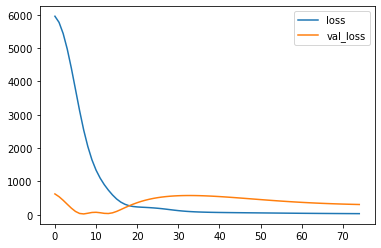

--------------------------------------- Current Engine : 69  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 132ms/step - loss: 12219.2773 - val_loss: 256.9530
Epoch 2/75
1/1 [==============================] - 0s 68ms/step - loss: 11928.5986 - val_loss: 261.9341
Epoch 3/75
1/1 [==============================] - 0s 30ms/step - loss: 11436.8340 - val_loss: 270.0752
Epoch 4/75
1/1 [==============================] - 0s 35ms/step - loss: 10805.0264 - val_loss: 281.6218
Epoch 5/75
1/1 [==============================] - 0s 33ms/step - loss: 10099.1523 - val_loss: 296.9781
Epoch 6/75
1/1 [==============================] - 0s 29ms/step - loss: 9372.9609 - val_loss: 316.6503
Epoch 7/75
1/1 [==============================] - 0s 23ms/step - loss: 8674.5332 - val_loss: 341.2012
Epoch 8/75
1/1 [==============================] - 0s 29ms/step - loss: 8031.8369 - val_loss: 371.1834
Epoch 9/75
1/1 [==============================] - 0s 29ms/step - loss: 7440.5

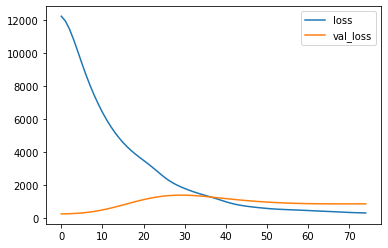

--------------------------------------- Current Engine : 70  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 44ms/step - loss: 25730.5352 - val_loss: 1207.4250
Epoch 2/75
1/1 [==============================] - 0s 39ms/step - loss: 25046.9980 - val_loss: 1109.0225
Epoch 3/75
1/1 [==============================] - 0s 22ms/step - loss: 23721.8125 - val_loss: 984.1414
Epoch 4/75
1/1 [==============================] - 0s 26ms/step - loss: 21794.7637 - val_loss: 844.7675
Epoch 5/75
1/1 [==============================] - 0s 27ms/step - loss: 19452.9707 - val_loss: 699.9115
Epoch 6/75
1/1 [==============================] - 0s 29ms/step - loss: 16980.2402 - val_loss: 556.3945
Epoch 7/75
1/1 [==============================] - 0s 27ms/step - loss: 14733.3896 - val_loss: 420.0013
Epoch 8/75
1/1 [==============================] - 0s 28ms/step - loss: 12819.4160 - val_loss: 296.3322
Epoch 9/75
1/1 [==============================] - 0s 26ms/step - loss: 11

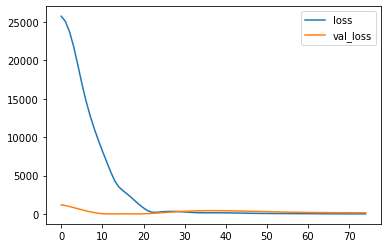

--------------------------------------- Current Engine : 71  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 59ms/step - loss: 2655.7124 - val_loss: 118.4831
Epoch 2/75
1/1 [==============================] - 0s 38ms/step - loss: 2374.1831 - val_loss: 123.1040
Epoch 3/75
1/1 [==============================] - 0s 36ms/step - loss: 2015.8370 - val_loss: 130.0253
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 1688.3203 - val_loss: 139.1997
Epoch 5/75
1/1 [==============================] - 0s 42ms/step - loss: 1420.9540 - val_loss: 150.5712
Epoch 6/75
1/1 [==============================] - 0s 21ms/step - loss: 1187.5060 - val_loss: 164.0456
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 960.4377 - val_loss: 179.4533
Epoch 8/75
1/1 [==============================] - 0s 38ms/step - loss: 744.2252 - val_loss: 196.5320
Epoch 9/75
1/1 [==============================] - 0s 42ms/step - loss: 563.5390 - val

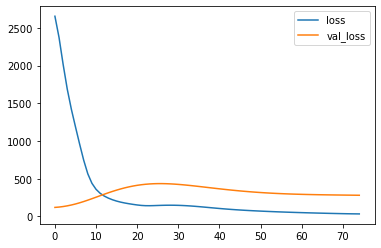

--------------------------------------- Current Engine : 72  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 65ms/step - loss: 305.3036 - val_loss: 721.4446
Epoch 2/75
1/1 [==============================] - 0s 28ms/step - loss: 288.4025 - val_loss: 712.0983
Epoch 3/75
1/1 [==============================] - 0s 29ms/step - loss: 260.3849 - val_loss: 698.5808
Epoch 4/75
1/1 [==============================] - 0s 27ms/step - loss: 229.9342 - val_loss: 681.5197
Epoch 5/75
1/1 [==============================] - 0s 25ms/step - loss: 204.0642 - val_loss: 661.4640
Epoch 6/75
1/1 [==============================] - 0s 24ms/step - loss: 186.0568 - val_loss: 638.8987
Epoch 7/75
1/1 [==============================] - 0s 30ms/step - loss: 174.2646 - val_loss: 614.2968
Epoch 8/75
1/1 [==============================] - 0s 28ms/step - loss: 165.5394 - val_loss: 588.1224
Epoch 9/75
1/1 [==============================] - 0s 32ms/step - loss: 157.5162 - val_loss:

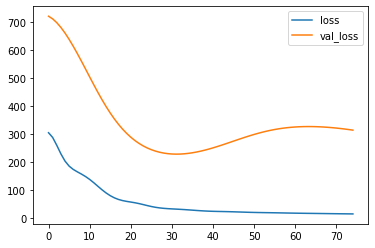

--------------------------------------- Current Engine : 73  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 106ms/step - loss: 1584.9688 - val_loss: 232.0196
Epoch 2/75
1/1 [==============================] - 0s 33ms/step - loss: 1420.2662 - val_loss: 279.1958
Epoch 3/75
1/1 [==============================] - 0s 34ms/step - loss: 1185.2792 - val_loss: 343.0458
Epoch 4/75
1/1 [==============================] - 0s 26ms/step - loss: 939.3425 - val_loss: 418.9956
Epoch 5/75
1/1 [==============================] - 0s 28ms/step - loss: 715.6041 - val_loss: 502.3248
Epoch 6/75
1/1 [==============================] - 0s 26ms/step - loss: 529.3191 - val_loss: 589.2264
Epoch 7/75
1/1 [==============================] - 0s 27ms/step - loss: 381.6910 - val_loss: 677.2300
Epoch 8/75
1/1 [==============================] - 0s 32ms/step - loss: 270.5709 - val_loss: 765.0034
Epoch 9/75
1/1 [==============================] - 0s 29ms/step - loss: 191.2400 - val_l

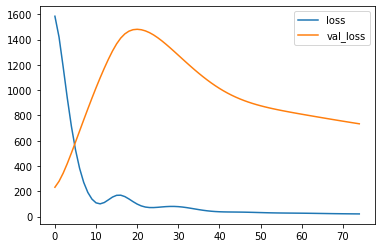

--------------------------------------- Current Engine : 74  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 50ms/step - loss: 1566.0371 - val_loss: 855.1086
Epoch 2/75
1/1 [==============================] - 0s 37ms/step - loss: 1392.5236 - val_loss: 842.6079
Epoch 3/75
1/1 [==============================] - 0s 38ms/step - loss: 1170.5177 - val_loss: 827.4005
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 956.5451 - val_loss: 810.1705
Epoch 5/75
1/1 [==============================] - 0s 41ms/step - loss: 779.4929 - val_loss: 791.6021
Epoch 6/75
1/1 [==============================] - 0s 42ms/step - loss: 645.3943 - val_loss: 772.2368
Epoch 7/75
1/1 [==============================] - 0s 30ms/step - loss: 547.8514 - val_loss: 752.5369
Epoch 8/75
1/1 [==============================] - 0s 29ms/step - loss: 480.5192 - val_loss: 732.8159
Epoch 9/75
1/1 [==============================] - 0s 27ms/step - loss: 433.8867 - val_lo

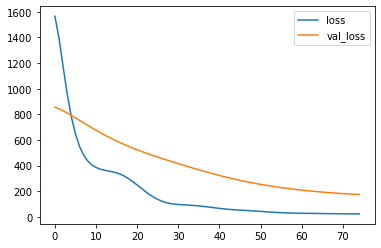

--------------------------------------- Current Engine : 75  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 72ms/step - loss: 565.0689 - val_loss: 146.5542
Epoch 2/75
1/1 [==============================] - 0s 28ms/step - loss: 518.8412 - val_loss: 147.4906
Epoch 3/75
1/1 [==============================] - 0s 28ms/step - loss: 439.1288 - val_loss: 149.5376
Epoch 4/75
1/1 [==============================] - 0s 13ms/step - loss: 342.9147 - val_loss: 152.8900
Epoch 5/75
1/1 [==============================] - 0s 24ms/step - loss: 250.1177 - val_loss: 157.8647
Epoch 6/75
1/1 [==============================] - 0s 30ms/step - loss: 172.9220 - val_loss: 164.9059
Epoch 7/75
1/1 [==============================] - 0s 34ms/step - loss: 115.1935 - val_loss: 174.5453
Epoch 8/75
1/1 [==============================] - 0s 30ms/step - loss: 77.6851 - val_loss: 187.3446
Epoch 9/75
1/1 [==============================] - 0s 31ms/step - loss: 57.9910 - val_loss: 2

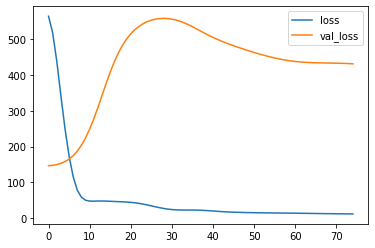

--------------------------------------- Current Engine : 76  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 59ms/step - loss: 382.3750 - val_loss: 235.4179
Epoch 2/75
1/1 [==============================] - 0s 36ms/step - loss: 362.8724 - val_loss: 247.1606
Epoch 3/75
1/1 [==============================] - 0s 24ms/step - loss: 329.8082 - val_loss: 263.9751
Epoch 4/75
1/1 [==============================] - 0s 28ms/step - loss: 289.2261 - val_loss: 285.2530
Epoch 5/75
1/1 [==============================] - 0s 32ms/step - loss: 246.6256 - val_loss: 310.3336
Epoch 6/75
1/1 [==============================] - 0s 32ms/step - loss: 205.9367 - val_loss: 338.5087
Epoch 7/75
1/1 [==============================] - 0s 29ms/step - loss: 169.3477 - val_loss: 369.0958
Epoch 8/75
1/1 [==============================] - 0s 29ms/step - loss: 137.8155 - val_loss: 401.5846
Epoch 9/75
1/1 [==============================] - 0s 24ms/step - loss: 111.7958 - val_loss:

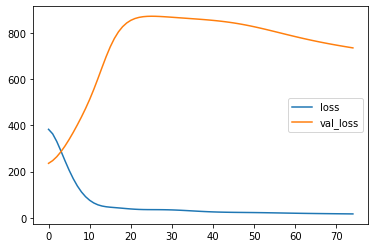

--------------------------------------- Current Engine : 77  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 61ms/step - loss: 2960.7563 - val_loss: 812.5468
Epoch 2/75
1/1 [==============================] - 0s 28ms/step - loss: 2813.8496 - val_loss: 791.3698
Epoch 3/75
1/1 [==============================] - 0s 27ms/step - loss: 2563.1685 - val_loss: 769.0708
Epoch 4/75
1/1 [==============================] - 0s 34ms/step - loss: 2247.4690 - val_loss: 748.1883
Epoch 5/75
1/1 [==============================] - 0s 40ms/step - loss: 1902.2831 - val_loss: 729.4627
Epoch 6/75
1/1 [==============================] - 0s 25ms/step - loss: 1559.1233 - val_loss: 712.7950
Epoch 7/75
1/1 [==============================] - 0s 26ms/step - loss: 1241.8474 - val_loss: 697.8937
Epoch 8/75
1/1 [==============================] - 0s 33ms/step - loss: 963.9849 - val_loss: 684.5044
Epoch 9/75
1/1 [==============================] - 0s 23ms/step - loss: 732.7944 - va

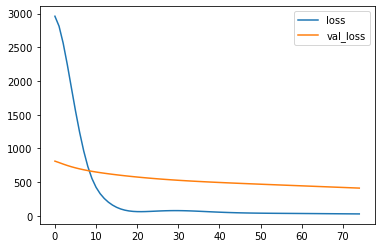

--------------------------------------- Current Engine : 78  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 75ms/step - loss: 1846.0533 - val_loss: 256.6580
Epoch 2/75
1/1 [==============================] - 0s 36ms/step - loss: 1719.7528 - val_loss: 256.2101
Epoch 3/75
1/1 [==============================] - 0s 33ms/step - loss: 1522.9316 - val_loss: 256.2419
Epoch 4/75
1/1 [==============================] - 0s 27ms/step - loss: 1292.6829 - val_loss: 256.6535
Epoch 5/75
1/1 [==============================] - 0s 28ms/step - loss: 1071.4767 - val_loss: 257.3337
Epoch 6/75
1/1 [==============================] - 0s 25ms/step - loss: 948.7937 - val_loss: 258.1688
Epoch 7/75
1/1 [==============================] - 0s 33ms/step - loss: 908.2204 - val_loss: 259.0787
Epoch 8/75
1/1 [==============================] - 0s 31ms/step - loss: 886.8101 - val_loss: 260.0331
Epoch 9/75
1/1 [==============================] - 0s 28ms/step - loss: 866.8632 - val_

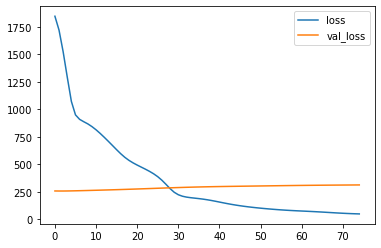

--------------------------------------- Current Engine : 79  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 55ms/step - loss: 333.1793 - val_loss: 349.6441
Epoch 2/75
1/1 [==============================] - 0s 27ms/step - loss: 300.6674 - val_loss: 349.0889
Epoch 3/75
1/1 [==============================] - 0s 29ms/step - loss: 245.1038 - val_loss: 348.2191
Epoch 4/75
1/1 [==============================] - 0s 29ms/step - loss: 176.6378 - val_loss: 347.1087
Epoch 5/75
1/1 [==============================] - 0s 27ms/step - loss: 108.5393 - val_loss: 345.8289
Epoch 6/75
1/1 [==============================] - 0s 38ms/step - loss: 53.6983 - val_loss: 344.4465
Epoch 7/75
1/1 [==============================] - 0s 27ms/step - loss: 23.6330 - val_loss: 343.0212
Epoch 8/75
1/1 [==============================] - 0s 44ms/step - loss: 22.5850 - val_loss: 341.5999
Epoch 9/75
1/1 [==============================] - 0s 36ms/step - loss: 42.5070 - val_loss: 340

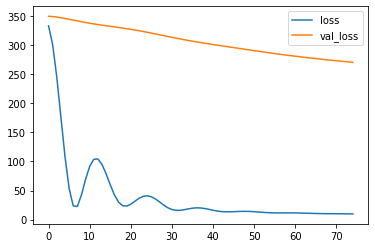

--------------------------------------- Current Engine : 80  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 81ms/step - loss: 697.2658 - val_loss: 242.3398
Epoch 2/75
1/1 [==============================] - 0s 34ms/step - loss: 683.8651 - val_loss: 248.6495
Epoch 3/75
1/1 [==============================] - 0s 32ms/step - loss: 659.1486 - val_loss: 257.7704
Epoch 4/75
1/1 [==============================] - 0s 23ms/step - loss: 625.7273 - val_loss: 269.3365
Epoch 5/75
1/1 [==============================] - 0s 24ms/step - loss: 586.1727 - val_loss: 282.9888
Epoch 6/75
1/1 [==============================] - 0s 38ms/step - loss: 542.8469 - val_loss: 298.3577
Epoch 7/75
1/1 [==============================] - 0s 24ms/step - loss: 497.7685 - val_loss: 315.0632
Epoch 8/75
1/1 [==============================] - 0s 28ms/step - loss: 452.5564 - val_loss: 332.7219
Epoch 9/75
1/1 [==============================] - 0s 28ms/step - loss: 408.4025 - val_loss:

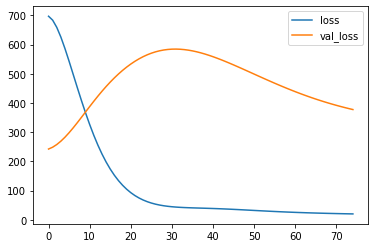

--------------------------------------- Current Engine : 81  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 60ms/step - loss: 2475.9980 - val_loss: 496.7417
Epoch 2/75
1/1 [==============================] - 0s 29ms/step - loss: 2394.2725 - val_loss: 497.8990
Epoch 3/75
1/1 [==============================] - 0s 34ms/step - loss: 2249.9233 - val_loss: 500.5546
Epoch 4/75
1/1 [==============================] - 0s 27ms/step - loss: 2067.8252 - val_loss: 504.5277
Epoch 5/75
1/1 [==============================] - 0s 28ms/step - loss: 1870.9753 - val_loss: 509.6415
Epoch 6/75
1/1 [==============================] - 0s 25ms/step - loss: 1671.0581 - val_loss: 515.7397
Epoch 7/75
1/1 [==============================] - 0s 30ms/step - loss: 1470.4816 - val_loss: 522.6714
Epoch 8/75
1/1 [==============================] - 0s 24ms/step - loss: 1280.8334 - val_loss: 530.2898
Epoch 9/75
1/1 [==============================] - 0s 40ms/step - loss: 1106.5629 - 

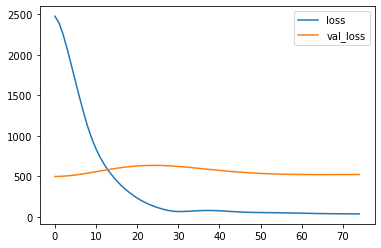

--------------------------------------- Current Engine : 82  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 92ms/step - loss: 3018.5322 - val_loss: 667.0155
Epoch 2/75
1/1 [==============================] - 0s 35ms/step - loss: 2847.3892 - val_loss: 651.7487
Epoch 3/75
1/1 [==============================] - 0s 36ms/step - loss: 2565.1931 - val_loss: 631.0134
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 2210.3855 - val_loss: 606.4592
Epoch 5/75
1/1 [==============================] - 0s 34ms/step - loss: 1834.7198 - val_loss: 579.5668
Epoch 6/75
1/1 [==============================] - 0s 27ms/step - loss: 1485.8475 - val_loss: 551.7039
Epoch 7/75
1/1 [==============================] - 0s 33ms/step - loss: 1171.6753 - val_loss: 523.9994
Epoch 8/75
1/1 [==============================] - 0s 30ms/step - loss: 912.3310 - val_loss: 497.2847
Epoch 9/75
1/1 [==============================] - 0s 27ms/step - loss: 712.1689 - va

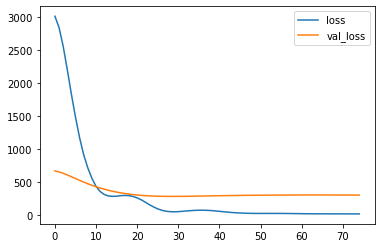

--------------------------------------- Current Engine : 83  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 62ms/step - loss: 3078.1101 - val_loss: 596.9603
Epoch 2/75
1/1 [==============================] - 0s 31ms/step - loss: 2911.8450 - val_loss: 597.6790
Epoch 3/75
1/1 [==============================] - 0s 29ms/step - loss: 2610.3831 - val_loss: 598.7299
Epoch 4/75
1/1 [==============================] - 0s 29ms/step - loss: 2214.3103 - val_loss: 599.9396
Epoch 5/75
1/1 [==============================] - 0s 30ms/step - loss: 1795.9197 - val_loss: 601.1680
Epoch 6/75
1/1 [==============================] - 0s 25ms/step - loss: 1406.5398 - val_loss: 602.2610
Epoch 7/75
1/1 [==============================] - 0s 29ms/step - loss: 1072.7158 - val_loss: 603.1082
Epoch 8/75
1/1 [==============================] - 0s 28ms/step - loss: 804.1921 - val_loss: 603.6309
Epoch 9/75
1/1 [==============================] - 0s 23ms/step - loss: 604.9375 - va

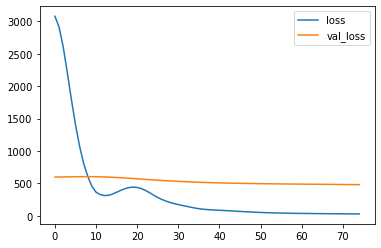

--------------------------------------- Current Engine : 84  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 62ms/step - loss: 2920.1453 - val_loss: 373.9784
Epoch 2/75
1/1 [==============================] - 0s 27ms/step - loss: 2829.2336 - val_loss: 386.6929
Epoch 3/75
1/1 [==============================] - 0s 28ms/step - loss: 2670.5132 - val_loss: 404.7825
Epoch 4/75
1/1 [==============================] - 0s 26ms/step - loss: 2463.6138 - val_loss: 427.8607
Epoch 5/75
1/1 [==============================] - 0s 33ms/step - loss: 2227.1453 - val_loss: 455.7064
Epoch 6/75
1/1 [==============================] - 0s 29ms/step - loss: 1975.9503 - val_loss: 488.0416
Epoch 7/75
1/1 [==============================] - 0s 28ms/step - loss: 1720.7740 - val_loss: 524.6815
Epoch 8/75
1/1 [==============================] - 0s 18ms/step - loss: 1470.1785 - val_loss: 565.5526
Epoch 9/75
1/1 [==============================] - 0s 42ms/step - loss: 1231.7434 - 

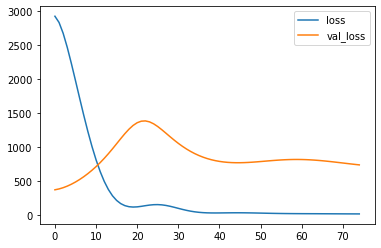

--------------------------------------- Current Engine : 85  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 60ms/step - loss: 7694.5259 - val_loss: 2144.1255
Epoch 2/75
1/1 [==============================] - 0s 27ms/step - loss: 7360.8667 - val_loss: 2057.2971
Epoch 3/75
1/1 [==============================] - 0s 27ms/step - loss: 6820.1016 - val_loss: 1954.8455
Epoch 4/75
1/1 [==============================] - 0s 33ms/step - loss: 6166.9565 - val_loss: 1846.2394
Epoch 5/75
1/1 [==============================] - 0s 35ms/step - loss: 5449.3828 - val_loss: 1737.6559
Epoch 6/75
1/1 [==============================] - 0s 24ms/step - loss: 4706.0146 - val_loss: 1632.5165
Epoch 7/75
1/1 [==============================] - 0s 24ms/step - loss: 3989.7290 - val_loss: 1532.4502
Epoch 8/75
1/1 [==============================] - 0s 23ms/step - loss: 3333.4578 - val_loss: 1438.1542
Epoch 9/75
1/1 [==============================] - 0s 27ms/step - loss: 2769

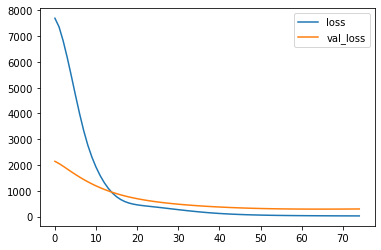

--------------------------------------- Current Engine : 86  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 66ms/step - loss: 4691.2090 - val_loss: 190.9920
Epoch 2/75
1/1 [==============================] - 0s 40ms/step - loss: 4620.7520 - val_loss: 199.9622
Epoch 3/75
1/1 [==============================] - 0s 39ms/step - loss: 4493.8125 - val_loss: 213.0271
Epoch 4/75
1/1 [==============================] - 0s 38ms/step - loss: 4326.8081 - val_loss: 230.2603
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 4133.8384 - val_loss: 251.5719
Epoch 6/75
1/1 [==============================] - 0s 33ms/step - loss: 3926.0396 - val_loss: 276.5934
Epoch 7/75
1/1 [==============================] - 0s 56ms/step - loss: 3711.6665 - val_loss: 304.7038
Epoch 8/75
1/1 [==============================] - 0s 37ms/step - loss: 3496.1169 - val_loss: 335.1897
Epoch 9/75
1/1 [==============================] - 0s 43ms/step - loss: 3283.5701 - 

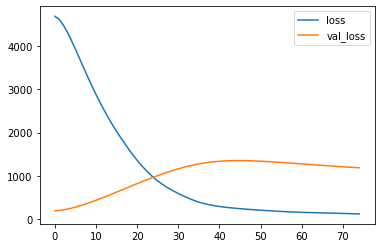

--------------------------------------- Current Engine : 87  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 68ms/step - loss: 6368.3496 - val_loss: 1725.7760
Epoch 2/75
1/1 [==============================] - 0s 32ms/step - loss: 6236.4810 - val_loss: 1701.5138
Epoch 3/75
1/1 [==============================] - 0s 28ms/step - loss: 6019.2642 - val_loss: 1671.7084
Epoch 4/75
1/1 [==============================] - 0s 27ms/step - loss: 5743.1328 - val_loss: 1637.8586
Epoch 5/75
1/1 [==============================] - 0s 29ms/step - loss: 5434.9878 - val_loss: 1601.2235
Epoch 6/75
1/1 [==============================] - 0s 47ms/step - loss: 5116.1567 - val_loss: 1562.8481
Epoch 7/75
1/1 [==============================] - 0s 39ms/step - loss: 4799.5093 - val_loss: 1523.5769
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 4488.9912 - val_loss: 1484.0762
Epoch 9/75
1/1 [==============================] - 0s 33ms/step - loss: 4181

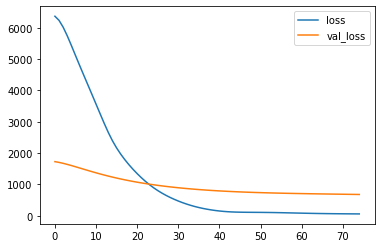

--------------------------------------- Current Engine : 88  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 69ms/step - loss: 350.2301 - val_loss: 533.8628
Epoch 2/75
1/1 [==============================] - 0s 23ms/step - loss: 343.4008 - val_loss: 532.7821
Epoch 3/75
1/1 [==============================] - 0s 31ms/step - loss: 333.4864 - val_loss: 531.7626
Epoch 4/75
1/1 [==============================] - 0s 29ms/step - loss: 321.2067 - val_loss: 530.7969
Epoch 5/75
1/1 [==============================] - 0s 29ms/step - loss: 307.2633 - val_loss: 529.8784
Epoch 6/75
1/1 [==============================] - 0s 28ms/step - loss: 292.2964 - val_loss: 529.0002
Epoch 7/75
1/1 [==============================] - 0s 27ms/step - loss: 276.8640 - val_loss: 528.1570
Epoch 8/75
1/1 [==============================] - 0s 29ms/step - loss: 261.4290 - val_loss: 527.3432
Epoch 9/75
1/1 [==============================] - 0s 28ms/step - loss: 246.3597 - val_loss:

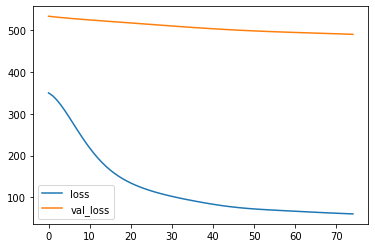

--------------------------------------- Current Engine : 89  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 97ms/step - loss: 232.1871 - val_loss: 502.6316
Epoch 2/75
1/1 [==============================] - 0s 35ms/step - loss: 231.0984 - val_loss: 502.0232
Epoch 3/75
1/1 [==============================] - 0s 36ms/step - loss: 229.0094 - val_loss: 501.2770
Epoch 4/75
1/1 [==============================] - 0s 33ms/step - loss: 226.0465 - val_loss: 500.4084
Epoch 5/75
1/1 [==============================] - 0s 24ms/step - loss: 222.3399 - val_loss: 499.4323
Epoch 6/75
1/1 [==============================] - 0s 67ms/step - loss: 218.0216 - val_loss: 498.3619
Epoch 7/75
1/1 [==============================] - 0s 44ms/step - loss: 213.2276 - val_loss: 497.2108
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 208.1022 - val_loss: 495.9898
Epoch 9/75
1/1 [==============================] - 0s 30ms/step - loss: 202.7961 - val_loss:

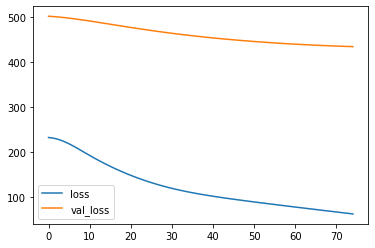

--------------------------------------- Current Engine : 90  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 81ms/step - loss: 2881.8604 - val_loss: 688.0193
Epoch 2/75
1/1 [==============================] - 0s 54ms/step - loss: 2779.2046 - val_loss: 684.8781
Epoch 3/75
1/1 [==============================] - 0s 37ms/step - loss: 2587.0471 - val_loss: 680.6365
Epoch 4/75
1/1 [==============================] - 0s 48ms/step - loss: 2314.5825 - val_loss: 675.4844
Epoch 5/75
1/1 [==============================] - 0s 34ms/step - loss: 1971.7595 - val_loss: 669.6113
Epoch 6/75
1/1 [==============================] - 0s 34ms/step - loss: 1585.4231 - val_loss: 663.1899
Epoch 7/75
1/1 [==============================] - 0s 29ms/step - loss: 1189.0331 - val_loss: 656.3792
Epoch 8/75
1/1 [==============================] - 0s 24ms/step - loss: 816.4899 - val_loss: 649.3058
Epoch 9/75
1/1 [==============================] - 0s 37ms/step - loss: 506.7797 - va

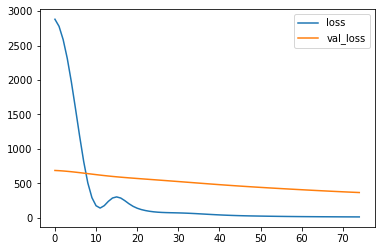

--------------------------------------- Current Engine : 91  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 69ms/step - loss: 466.0102 - val_loss: 393.4639
Epoch 2/75
1/1 [==============================] - 0s 32ms/step - loss: 437.0644 - val_loss: 409.0639
Epoch 3/75
1/1 [==============================] - 0s 34ms/step - loss: 389.0860 - val_loss: 429.6278
Epoch 4/75
1/1 [==============================] - 0s 32ms/step - loss: 331.5179 - val_loss: 453.3845
Epoch 5/75
1/1 [==============================] - 0s 31ms/step - loss: 271.7119 - val_loss: 479.1406
Epoch 6/75
1/1 [==============================] - 0s 33ms/step - loss: 215.2645 - val_loss: 506.2189
Epoch 7/75
1/1 [==============================] - 0s 35ms/step - loss: 165.8051 - val_loss: 534.3390
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 125.9905 - val_loss: 563.5237
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 97.0525 - val_loss: 

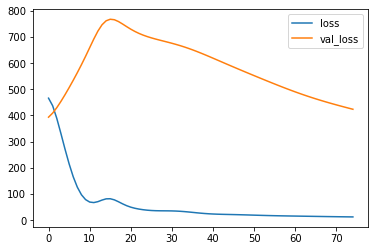

--------------------------------------- Current Engine : 92  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 55ms/step - loss: 19550.4609 - val_loss: 208.7584
Epoch 2/75
1/1 [==============================] - 0s 43ms/step - loss: 18846.0527 - val_loss: 210.0338
Epoch 3/75
1/1 [==============================] - 0s 43ms/step - loss: 17779.4746 - val_loss: 212.2490
Epoch 4/75
1/1 [==============================] - 0s 39ms/step - loss: 16541.5059 - val_loss: 215.5042
Epoch 5/75
1/1 [==============================] - 0s 35ms/step - loss: 15311.7285 - val_loss: 219.9122
Epoch 6/75
1/1 [==============================] - 0s 26ms/step - loss: 14209.3701 - val_loss: 225.5661
Epoch 7/75
1/1 [==============================] - 0s 26ms/step - loss: 13257.4766 - val_loss: 232.5212
Epoch 8/75
1/1 [==============================] - 0s 33ms/step - loss: 12422.2188 - val_loss: 240.7944
Epoch 9/75
1/1 [==============================] - 0s 30ms/step - loss: 1164

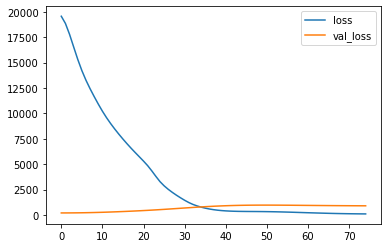

--------------------------------------- Current Engine : 93  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 99ms/step - loss: 25985.7930 - val_loss: 1504.2822
Epoch 2/75
1/1 [==============================] - 0s 39ms/step - loss: 24504.5801 - val_loss: 1484.1298
Epoch 3/75
1/1 [==============================] - 0s 42ms/step - loss: 22186.6504 - val_loss: 1458.1732
Epoch 4/75
1/1 [==============================] - 0s 55ms/step - loss: 19593.8047 - val_loss: 1428.6505
Epoch 5/75
1/1 [==============================] - 0s 44ms/step - loss: 16994.0645 - val_loss: 1397.2009
Epoch 6/75
1/1 [==============================] - 0s 52ms/step - loss: 14590.1514 - val_loss: 1364.9253
Epoch 7/75
1/1 [==============================] - 0s 74ms/step - loss: 12681.7637 - val_loss: 1332.5065
Epoch 8/75
1/1 [==============================] - 0s 54ms/step - loss: 11391.2803 - val_loss: 1300.3232
Epoch 9/75
1/1 [==============================] - 0s 38ms/step - lo

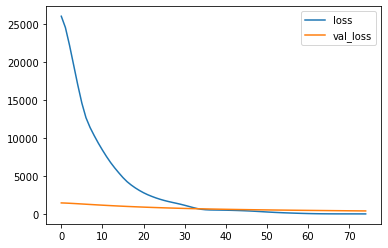

--------------------------------------- Current Engine : 94  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 83ms/step - loss: 5419.2466 - val_loss: 249.2921
Epoch 2/75
1/1 [==============================] - 0s 32ms/step - loss: 5323.2349 - val_loss: 259.4601
Epoch 3/75
1/1 [==============================] - 0s 28ms/step - loss: 5147.6685 - val_loss: 274.2978
Epoch 4/75
1/1 [==============================] - 0s 26ms/step - loss: 4914.2876 - val_loss: 292.9533
Epoch 5/75
1/1 [==============================] - 0s 24ms/step - loss: 4638.6328 - val_loss: 314.6250
Epoch 6/75
1/1 [==============================] - 0s 26ms/step - loss: 4329.3408 - val_loss: 338.5702
Epoch 7/75
1/1 [==============================] - 0s 26ms/step - loss: 3995.3967 - val_loss: 364.1951
Epoch 8/75
1/1 [==============================] - 0s 29ms/step - loss: 3648.0220 - val_loss: 391.1525
Epoch 9/75
1/1 [==============================] - 0s 27ms/step - loss: 3293.8081 - 

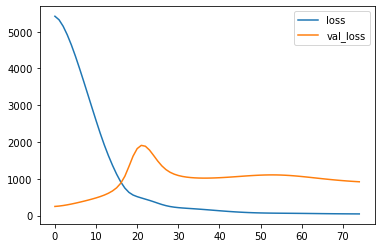

--------------------------------------- Current Engine : 95  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 78ms/step - loss: 6206.8594 - val_loss: 904.5591
Epoch 2/75
1/1 [==============================] - 0s 28ms/step - loss: 5905.7798 - val_loss: 899.9075
Epoch 3/75
1/1 [==============================] - 0s 30ms/step - loss: 5522.2847 - val_loss: 896.2603
Epoch 4/75
1/1 [==============================] - 0s 29ms/step - loss: 5181.1177 - val_loss: 893.4755
Epoch 5/75
1/1 [==============================] - 0s 32ms/step - loss: 4886.1978 - val_loss: 891.4077
Epoch 6/75
1/1 [==============================] - 0s 28ms/step - loss: 4613.2266 - val_loss: 889.9442
Epoch 7/75
1/1 [==============================] - 0s 27ms/step - loss: 4355.6118 - val_loss: 888.9929
Epoch 8/75
1/1 [==============================] - 0s 33ms/step - loss: 4100.4990 - val_loss: 888.4668
Epoch 9/75
1/1 [==============================] - 0s 55ms/step - loss: 3848.9644 - 

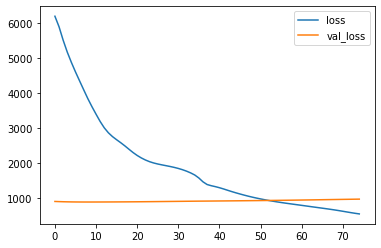

--------------------------------------- Current Engine : 96  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 67ms/step - loss: 3842.1794 - val_loss: 1017.8070
Epoch 2/75
1/1 [==============================] - 0s 30ms/step - loss: 3717.6365 - val_loss: 1025.0383
Epoch 3/75
1/1 [==============================] - 0s 30ms/step - loss: 3538.2075 - val_loss: 1034.5728
Epoch 4/75
1/1 [==============================] - 0s 36ms/step - loss: 3328.9219 - val_loss: 1046.2788
Epoch 5/75
1/1 [==============================] - 0s 33ms/step - loss: 3118.0703 - val_loss: 1060.0643
Epoch 6/75
1/1 [==============================] - 0s 29ms/step - loss: 2924.0168 - val_loss: 1075.8950
Epoch 7/75
1/1 [==============================] - 0s 32ms/step - loss: 2750.8374 - val_loss: 1093.7843
Epoch 8/75
1/1 [==============================] - 0s 31ms/step - loss: 2595.7759 - val_loss: 1113.8098
Epoch 9/75
1/1 [==============================] - 0s 35ms/step - loss: 2456

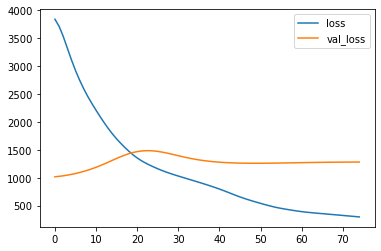

--------------------------------------- Current Engine : 97  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 81ms/step - loss: 11510.4668 - val_loss: 1610.8329
Epoch 2/75
1/1 [==============================] - 0s 34ms/step - loss: 11191.3867 - val_loss: 1601.5455
Epoch 3/75
1/1 [==============================] - 0s 30ms/step - loss: 10634.8369 - val_loss: 1588.0941
Epoch 4/75
1/1 [==============================] - 0s 30ms/step - loss: 9889.7617 - val_loss: 1571.4253
Epoch 5/75
1/1 [==============================] - 0s 30ms/step - loss: 9007.0674 - val_loss: 1552.3881
Epoch 6/75
1/1 [==============================] - 0s 34ms/step - loss: 8064.4844 - val_loss: 1531.7159
Epoch 7/75
1/1 [==============================] - 0s 28ms/step - loss: 7117.9360 - val_loss: 1510.0281
Epoch 8/75
1/1 [==============================] - 0s 40ms/step - loss: 6218.3252 - val_loss: 1487.7925
Epoch 9/75
1/1 [==============================] - 0s 46ms/step - loss: 5

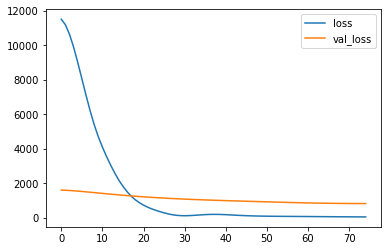

--------------------------------------- Current Engine : 98  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 77ms/step - loss: 1024.1886 - val_loss: 7590.8125
Epoch 2/75
1/1 [==============================] - 0s 32ms/step - loss: 940.3886 - val_loss: 6996.9077
Epoch 3/75
1/1 [==============================] - 0s 38ms/step - loss: 810.0891 - val_loss: 6298.1758
Epoch 4/75
1/1 [==============================] - 0s 41ms/step - loss: 662.2535 - val_loss: 5582.1870
Epoch 5/75
1/1 [==============================] - 0s 43ms/step - loss: 521.0612 - val_loss: 4906.1680
Epoch 6/75
1/1 [==============================] - 0s 44ms/step - loss: 401.0464 - val_loss: 4299.7358
Epoch 7/75
1/1 [==============================] - 0s 34ms/step - loss: 305.6204 - val_loss: 3771.8782
Epoch 8/75
1/1 [==============================] - 0s 36ms/step - loss: 232.8296 - val_loss: 3319.2502
Epoch 9/75
1/1 [==============================] - 0s 31ms/step - loss: 180.4322 - 

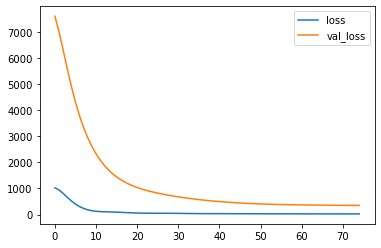

--------------------------------------- Current Engine : 99  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 97ms/step - loss: 279.7506 - val_loss: 417.6754
Epoch 2/75
1/1 [==============================] - 0s 51ms/step - loss: 274.1188 - val_loss: 416.1541
Epoch 3/75
1/1 [==============================] - 0s 46ms/step - loss: 263.9951 - val_loss: 414.5387
Epoch 4/75
1/1 [==============================] - 0s 39ms/step - loss: 250.2842 - val_loss: 412.9549
Epoch 5/75
1/1 [==============================] - 0s 64ms/step - loss: 233.9941 - val_loss: 411.5204
Epoch 6/75
1/1 [==============================] - 0s 46ms/step - loss: 216.1734 - val_loss: 410.3345
Epoch 7/75
1/1 [==============================] - 0s 45ms/step - loss: 197.9108 - val_loss: 409.4714
Epoch 8/75
1/1 [==============================] - 0s 41ms/step - loss: 180.2784 - val_loss: 408.9787
Epoch 9/75
1/1 [==============================] - 0s 45ms/step - loss: 164.0977 - val_loss:

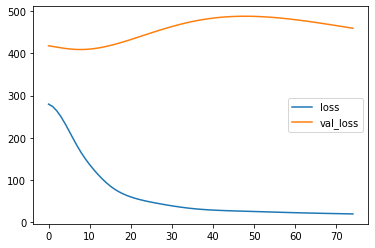

--------------------------------------- Current Engine : 100  ---------------------------------------
Epoch 1/75
1/1 [==============================] - 0s 57ms/step - loss: 1103.1807 - val_loss: 400.1900
Epoch 2/75
1/1 [==============================] - 0s 36ms/step - loss: 1046.9523 - val_loss: 415.5083
Epoch 3/75
1/1 [==============================] - 0s 24ms/step - loss: 954.1122 - val_loss: 436.8628
Epoch 4/75
1/1 [==============================] - 0s 41ms/step - loss: 840.1588 - val_loss: 462.9174
Epoch 5/75
1/1 [==============================] - 0s 36ms/step - loss: 719.4693 - val_loss: 492.3844
Epoch 6/75
1/1 [==============================] - 0s 49ms/step - loss: 605.2183 - val_loss: 524.0438
Epoch 7/75
1/1 [==============================] - 0s 43ms/step - loss: 505.1764 - val_loss: 556.8016
Epoch 8/75
1/1 [==============================] - 0s 54ms/step - loss: 419.6392 - val_loss: 589.7366
Epoch 9/75
1/1 [==============================] - 0s 34ms/step - loss: 348.4097 - val_lo

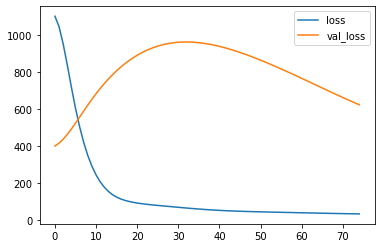

In [20]:
for i in range(len(X_train_new)):
    print("--------------------------------------- Current Engine :",i+1," ---------------------------------------")
    history = model.fit(
    X_train_new[i],
    y_train_new[i],
    batch_size=512,
    epochs=75,
    validation_split=0.15,
    verbose=1)
    # Loss Graph
    plt.plot(history.epoch, history.history['loss'] , label = "loss")
    plt.plot(history.epoch, history.history['val_loss'] , label = "val_loss")
    plt.legend()
    plt.show()

In [21]:
mses=[]
rmses=[]
maes=[]
for i in range(len(X_train_new)):
    
    print("--------------------------------------- Current Engine :",i+1," ---------------------------------------")
    
    y_train_pred = model.predict(X_train_new[i])
    
    mses.append(mean_squared_error(y_train_new[i],y_train_pred))
    rmses.append(math.sqrt(mean_squared_error(y_train_new[i],y_train_pred)))
    maes.append(mean_absolute_error(y_train_new[i],y_train_pred))
    
    print("mean_squared_error >> ", mean_squared_error(y_train_new[i],y_train_pred))
    print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_train_new[i],y_train_pred)))
    print("mean_absolute_error >>",mean_absolute_error(y_train_new[i],y_train_pred))

--------------------------------------- Current Engine : 1  ---------------------------------------
mean_squared_error >>  1173.2285943378379
root_mean_squared_error >>  34.252424649035255
mean_absolute_error >> 29.323573922598232
--------------------------------------- Current Engine : 2  ---------------------------------------
mean_squared_error >>  3159.869588385657
root_mean_squared_error >>  56.212717318998706
mean_absolute_error >> 44.90753275643888
--------------------------------------- Current Engine : 3  ---------------------------------------
mean_squared_error >>  695.9073836281397
root_mean_squared_error >>  26.38005655088972
mean_absolute_error >> 25.064634554647984
--------------------------------------- Current Engine : 4  ---------------------------------------
mean_squared_error >>  461.1473914671028
root_mean_squared_error >>  21.474342631780438
mean_absolute_error >> 19.995211033221803
--------------------------------------- Current Engine : 5  ---------------------

root_mean_squared_error >>  73.32296685461264
mean_absolute_error >> 68.53844814765745
--------------------------------------- Current Engine : 38  ---------------------------------------
mean_squared_error >>  2237.7316653307794
root_mean_squared_error >>  47.304668536316576
mean_absolute_error >> 38.25781337251055
--------------------------------------- Current Engine : 39  ---------------------------------------
mean_squared_error >>  17108.495579689115
root_mean_squared_error >>  130.79944793342636
mean_absolute_error >> 127.32969127717566
--------------------------------------- Current Engine : 40  ---------------------------------------
mean_squared_error >>  2386.2681871431832
root_mean_squared_error >>  48.849444082232736
mean_absolute_error >> 40.802698177295724
--------------------------------------- Current Engine : 41  ---------------------------------------
mean_squared_error >>  441.1726822921066
root_mean_squared_error >>  21.004111080740994
mean_absolute_error >> 18.687

mean_squared_error >>  2662.8278422104845
root_mean_squared_error >>  51.602595304989116
mean_absolute_error >> 47.84549058923399
--------------------------------------- Current Engine : 74  ---------------------------------------
mean_squared_error >>  882.4254996841061
root_mean_squared_error >>  29.705647605869597
mean_absolute_error >> 28.809435153007506
--------------------------------------- Current Engine : 75  ---------------------------------------
mean_squared_error >>  1560.7985417434681
root_mean_squared_error >>  39.50694295618769
mean_absolute_error >> 36.93705838464301
--------------------------------------- Current Engine : 76  ---------------------------------------
mean_squared_error >>  1689.9027741550663
root_mean_squared_error >>  41.10842704549842
mean_absolute_error >> 34.8946060666851
--------------------------------------- Current Engine : 77  ---------------------------------------
mean_squared_error >>  6372.2474423786325
root_mean_squared_error >>  79.826358

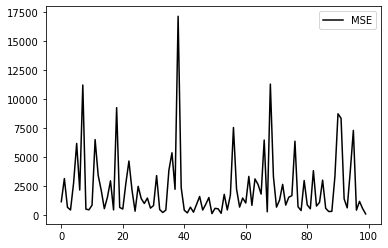

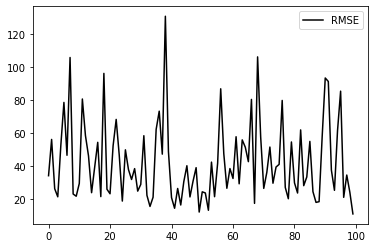

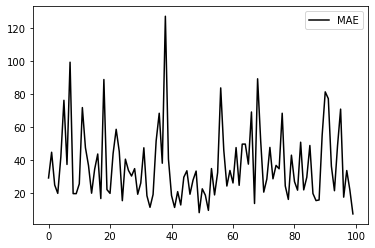

In [45]:
plt.plot(mses,c='k',label='MSE')
#plt.plot(rmses,c='red',label='RMSE')
plt.legend()
plt.show()

plt.plot(rmses,c='k',label='RMSE')
plt.legend()
plt.show()

plt.plot(maes,c='k',label='MAE')
#plt.plot(rmses,c='red',label='RMSE')
plt.legend()
plt.show()

In [22]:
mses = np.array(mses)
rmses = np.array(rmses)
maes = np.array(maes)

print("MSE :",np.mean(mses))
print("RMSES :",np.mean(rmses))
print("MAES :",np.mean(maes))

MSE : 2369.6707723100717
RMSES : 42.422421473227544
MAES : 36.97047456434121


# <a id='testing'>4 Testing</a>
<a href='#index'>Go back to Index</a>

In [23]:
df_test = pd.read_csv(test_file, sep=" ",header=None)
df_test.drop(columns=[26,27],inplace=True)
df_test.columns = columns
df_test.head()

,Section-0,Section-1,Section-2,Section-3,Section-4,Section-5,Section-6,Section-7,Section-8,Section-9,...,Section-16,Section-17,Section-18,Section-19,Section-20,Section-21,Section-22,Section-23,Section-24,Section-25
0,1,1,0.0023,0.0003,100.0,518.67,643.02,1585.29,1398.21,14.62,...,521.72,2388.03,8125.55,8.4052,0.03,392,2388,100.0,38.86,23.3735
1,1,2,-0.0027,-0.0003,100.0,518.67,641.71,1588.45,1395.42,14.62,...,522.16,2388.06,8139.62,8.3803,0.03,393,2388,100.0,39.02,23.3916
2,1,3,0.0003,0.0001,100.0,518.67,642.46,1586.94,1401.34,14.62,...,521.97,2388.03,8130.10,8.4441,0.03,393,2388,100.0,39.08,23.4166
3,1,4,0.0042,0.0000,100.0,518.67,642.44,1584.12,1406.42,14.62,...,521.38,2388.05,8132.90,8.3917,0.03,391,2388,100.0,39.00,23.3737
4,1,5,0.0014,0.0000,100.0,518.67,642.51,1587.19,1401.92,14.62,...,522.15,2388.03,8129.54,8.4031,0.03,390,2388,100.0,38.99,23.4130


In [24]:
df_rul = pd.read_csv(RUL_file, names=['rul'])
df_rul.head()

,rul
0,112
1,98
2,69
3,82
4,91


In [25]:
RUL_name = ["Section-1"]
RUL_data = df_test[RUL_name]
MachineID_series = df_test["Section-0"]
grp = RUL_data.groupby(MachineID_series)
max_cycles = np.array([max(grp.get_group(i)["Section-1"]) for i in MachineID_series.unique()])
#max_cycles[0] = max_cycles[0] - 21

In [26]:
df_test.drop(df_test[["Section-0",
                "Section-4", # Operatinal Setting
                "Section-5", # Sensor data
                "Section-9", # Sensor data
                "Section-10", # Sensor data
                "Section-14",# Sensor data
                "Section-20",# Sensor data
                "Section-22",# Sensor data
                "Section-23"]], axis=1 , inplace=True)
#df_test = df_test.groupby(["Section-0"])
#print(df_test)


In [27]:
gen = MinMaxScaler(feature_range=(0, 1))
df_test = gen.fit_transform(df_test)
df_test = pd.DataFrame(df_test)
#df_test = df_test.rolling(20).mean()
pt = PowerTransformer()
df_test = pt.fit_transform(df_test)
df_test=np.nan_to_num(df_test)

In [28]:
X_test = np.array(df_test)

y_test = np.array(df_rul)

print(X_test.shape,y_test.shape)
print(max_cycles)

(13096, 17) (100, 1)
[ 31  49 126 106  98 105 160 166  55 192  83 217 195  46  76 113 165 133
 135 184 148  39 130 186  48  76 140 158 171 143 196 145  50 203 198 126
 121 125  37 133 123 156 172  54 152 146  73  78 303  74 144 189 164 121
 113 136 160 176  94 147 159 232 155 168  71 147  71 187  54 152  68 131
 112 137  88 205 162  72 101 133 213 162  73 172  34 110  56  68 177 146
 234 150 244 133  89  97 134 121  97 198]


In [29]:
X_test_new = []
i = 0
count = 0
while i < len(X_test):
    temp_x = []
    j = int(max_cycles[count])
    count = count+1
    if j == 0:
        break
    while j!=0:
        temp_x.append(X_test[i])
        i=i+1
        j=j-1
    X_test_new.append(temp_x)

In [30]:
def create_dataset(X, look_back=5):
    data = []
    for i in range(len(X)-look_back-1):
        data.append(X[i:(i+look_back)])
    return np.array(data)

In [31]:
for i in range(len(X_test_new)):
    X_test_new[i] = create_dataset(X_test_new[i])
#y_test = y_test[6:]

In [32]:
using_mean = []
using_last_index = []
predictions = []
for i in range(len(X_test_new)):
    print("-------------------------Current Engine :",i+1,"-----------------------------")
    pred = model.predict(X_test_new[i])
    using_mean.append(np.mean(pred))
    using_last_index.append(pred[-1])
    print("Actual RUL :",y_test[i])
    print("Predicted using last index :",pred[-1])
    print("Predicted using mean :",np.mean(pred))
    predictions.append(pred)

-------------------------Current Engine : 1 -----------------------------
Actual RUL : [112]
Predicted using last index : [172.41643]
Predicted using mean : 177.79567
-------------------------Current Engine : 2 -----------------------------
Actual RUL : [98]
Predicted using last index : [182.9528]
Predicted using mean : 226.91649
-------------------------Current Engine : 3 -----------------------------
Actual RUL : [69]
Predicted using last index : [48.52794]
Predicted using mean : 121.54761
-------------------------Current Engine : 4 -----------------------------
Actual RUL : [82]
Predicted using last index : [44.152344]
Predicted using mean : 149.6343
-------------------------Current Engine : 5 -----------------------------
Actual RUL : [91]
Predicted using last index : [54.947746]
Predicted using mean : 159.1847
-------------------------Current Engine : 6 -----------------------------
Actual RUL : [93]
Predicted using last index : [53.983875]
Predicted using mean : 147.97453
-------

Actual RUL : [79]
Predicted using last index : [93.08037]
Predicted using mean : 136.92491
-------------------------Current Engine : 51 -----------------------------
Actual RUL : [114]
Predicted using last index : [60.945194]
Predicted using mean : 138.28842
-------------------------Current Engine : 52 -----------------------------
Actual RUL : [29]
Predicted using last index : [45.59274]
Predicted using mean : 107.83981
-------------------------Current Engine : 53 -----------------------------
Actual RUL : [26]
Predicted using last index : [43.921326]
Predicted using mean : 102.32125
-------------------------Current Engine : 54 -----------------------------
Actual RUL : [97]
Predicted using last index : [100.81252]
Predicted using mean : 126.12708
-------------------------Current Engine : 55 -----------------------------
Actual RUL : [137]
Predicted using last index : [91.05392]
Predicted using mean : 129.601
-------------------------Current Engine : 56 -----------------------------
A

Actual RUL : [20]
Predicted using last index : [44.49315]
Predicted using mean : 100.176506


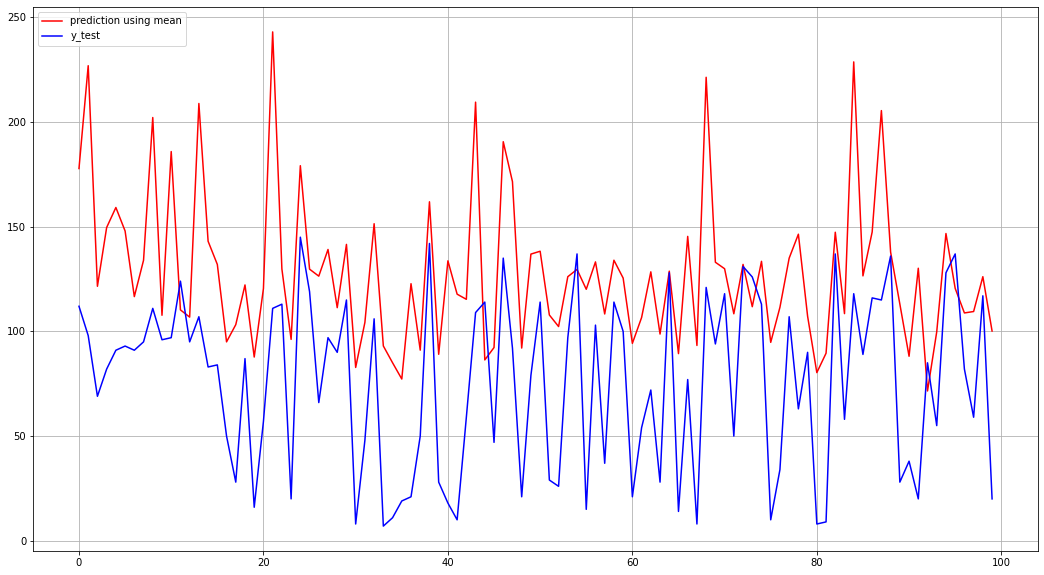

In [46]:
fig = plt.figure(figsize=(18,10))
plt.plot(using_mean,color='red', label='prediction using mean')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.grid()
plt.show()

In [47]:
print("mean_squared_error >> ", mean_squared_error(y_test,using_mean))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,using_mean)))
print("mean_absolute_error >>",mean_absolute_error(y_test,using_mean))

mean_squared_error >>  3970.75457695151
root_mean_squared_error >>  63.01392367526014
mean_absolute_error >> 54.55408004760742


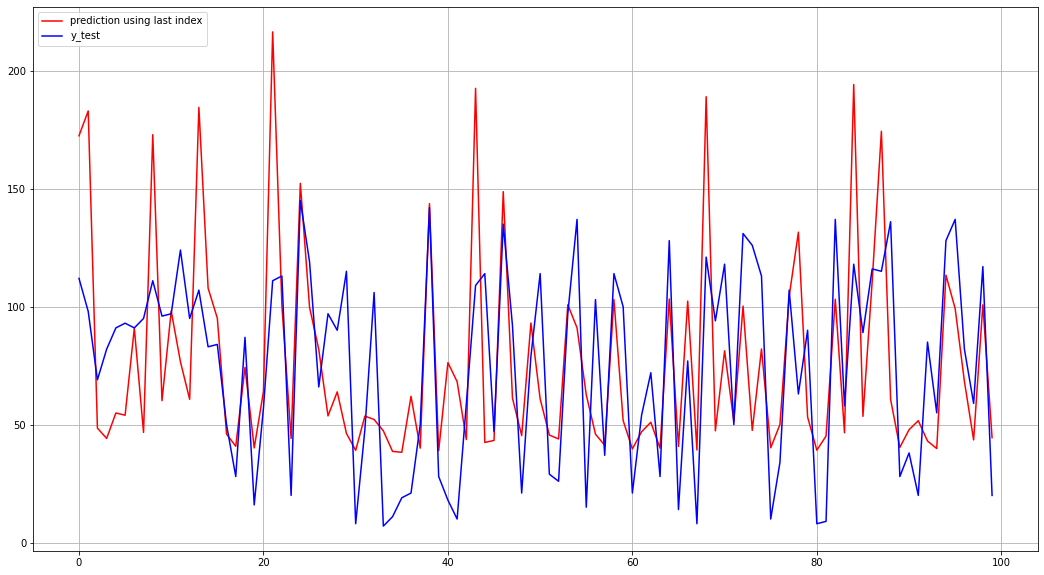

mean_squared_error >>  1504.8475042400958
root_mean_squared_error >>  38.792363993962724
mean_absolute_error >> 31.36578838348389


In [48]:
fig = plt.figure(figsize=(18,10))
plt.plot(using_last_index,color='red', label='prediction using last index')
plt.plot(y_test,color='blue', label='y_test')
plt.legend(loc='upper left')
plt.grid()
plt.show()

print("mean_squared_error >> ", mean_squared_error(y_test,using_last_index))
print("root_mean_squared_error >> ", math.sqrt(mean_squared_error(y_test,using_last_index)))
print("mean_absolute_error >>",mean_absolute_error(y_test,using_last_index))

In [36]:
a = y_test

In [37]:
my_pred = using_last_index

In [38]:
actual = []
for i in range(len(a)):
    actual.append(a[i][0])

In [39]:
print(actual)

[112, 98, 69, 82, 91, 93, 91, 95, 111, 96, 97, 124, 95, 107, 83, 84, 50, 28, 87, 16, 57, 111, 113, 20, 145, 119, 66, 97, 90, 115, 8, 48, 106, 7, 11, 19, 21, 50, 142, 28, 18, 10, 59, 109, 114, 47, 135, 92, 21, 79, 114, 29, 26, 97, 137, 15, 103, 37, 114, 100, 21, 54, 72, 28, 128, 14, 77, 8, 121, 94, 118, 50, 131, 126, 113, 10, 34, 107, 63, 90, 8, 9, 137, 58, 118, 89, 116, 115, 136, 28, 38, 20, 85, 55, 128, 137, 82, 59, 117, 20]


In [40]:
print(my_pred)

[array([172.41643], dtype=float32), array([182.9528], dtype=float32), array([48.52794], dtype=float32), array([44.152344], dtype=float32), array([54.947746], dtype=float32), array([53.983875], dtype=float32), array([90.89025], dtype=float32), array([46.704113], dtype=float32), array([172.89555], dtype=float32), array([60.1424], dtype=float32), array([98.15913], dtype=float32), array([76.6477], dtype=float32), array([60.73431], dtype=float32), array([184.47801], dtype=float32), array([107.846535], dtype=float32), array([95.130035], dtype=float32), array([46.005512], dtype=float32), array([40.818005], dtype=float32), array([74.276276], dtype=float32), array([40.12683], dtype=float32), array([64.02907], dtype=float32), array([216.45575], dtype=float32), array([100.45526], dtype=float32), array([44.146442], dtype=float32), array([152.27502], dtype=float32), array([99.710976], dtype=float32), array([81.859055], dtype=float32), array([53.70152], dtype=float32), array([63.88912], dtype=float3

In [41]:
overestimation = []
percentage_errors = [[],[],[],[],[],[],[],[],[],[],[]]
for i in range(len(my_pred)):
    percentage_error = ((my_pred[i]-actual[i])/actual[i])*100
#     print(abs(int(percentage_error/10)))
    print("For engine",i,"overestimated RUL is :",percentage_error)
    if abs(int(percentage_error/10)) < 10:
        percentage_errors[abs(int(percentage_error/10))].append(percentage_error)
    else:
        percentage_errors[10].append(percentage_error)
    overestimation.append(my_pred[i]-actual[i])

For engine 0 overestimated RUL is : [53.94324]
For engine 1 overestimated RUL is : [86.68653]
For engine 2 overestimated RUL is : [-29.669655]
For engine 3 overestimated RUL is : [-46.155678]
For engine 4 overestimated RUL is : [-39.61786]
For engine 5 overestimated RUL is : [-41.95282]
For engine 6 overestimated RUL is : [-0.12060312]
For engine 7 overestimated RUL is : [-50.837772]
For engine 8 overestimated RUL is : [55.76176]
For engine 9 overestimated RUL is : [-37.35167]
For engine 10 overestimated RUL is : [1.1949755]
For engine 11 overestimated RUL is : [-38.18734]
For engine 12 overestimated RUL is : [-36.069145]
For engine 13 overestimated RUL is : [72.409355]
For engine 14 overestimated RUL is : [29.935583]
For engine 15 overestimated RUL is : [13.250043]
For engine 16 overestimated RUL is : [-7.988975]
For engine 17 overestimated RUL is : [45.778587]
For engine 18 overestimated RUL is : [-14.624971]
For engine 19 overestimated RUL is : [150.7927]
For engine 20 overestimated

In [42]:
positive,negative,zeros = 0,0,0
for i in range(len(overestimation)):
    if overestimation[i] < 0:
        negative = negative + 1
    elif overestimation[i] > 0:
        positive = positive + 1
    else:
        zeros = zeros + 1

In [43]:
print("Overestimated RUL :",positive)
print("Underestimated RUL :",negative)
print("Correctly predicted RUL :",zeros)

Overestimated RUL : 51
Underestimated RUL : 49
Correctly predicted RUL : 0


In [44]:
for p in range(11):    
    if p < 10:
        print('Between',p*10,'and',(p+1)*10,'%','are :',len(percentage_errors[p]),'\n',percentage_errors[p],'\n\n')
    else:
        print('Over',p*10,'% are',len(percentage_errors[p]),'\n',percentage_errors[p],'\n\n')

Between 0 and 10 % are : 11 
 [array([-0.12060312], dtype=float32), array([1.1949755], dtype=float32), array([-7.988975], dtype=float32), array([5.017258], dtype=float32), array([1.1812667], dtype=float32), array([-7.84693], dtype=float32), array([3.9304361], dtype=float32), array([-9.636441], dtype=float32), array([2.6321945], dtype=float32), array([-2.5017498], dtype=float32), array([-4.6354623], dtype=float32)] 


Between 10 and 20 % are : 16 
 [array([13.250043], dtype=float32), array([-14.624971], dtype=float32), array([12.331698], dtype=float32), array([-11.101539], dtype=float32), array([-16.209265], dtype=float32), array([11.70671], dtype=float32), array([-19.92527], dtype=float32), array([10.183535], dtype=float32), array([17.82325], dtype=float32), array([11.570049], dtype=float32), array([-13.009651], dtype=float32), array([-19.334501], dtype=float32), array([-19.748793], dtype=float32), array([-11.430139], dtype=float32), array([-16.675306], dtype=float32), array([-13.85110